# Прогнозирование количества заказов такси

---

**Входные данные**

Исторические данные о заказах такси в аэропортах.

---

**Цель**

Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо построить модель для прогнозирования количества заказов такси на следующий час.

---

**Задачи:**  

- загрузить данные и выполнить их ресемплирование по одному часу;
- проанализировать данные;
- подготовить данные для обучения и тестирования модели, под тестовую выборку выделить 10% данных;
- обучить несколько моделей;
- выбрать лучшую модель;
- проанализировать выбранную модель, значение метрики RMSE на тестовой выборке должно быть менее 48.

---

## Intro

**Пояснения**

---

Постоянные таблицы с данными начинаются со слова **data** .  
Временные таблицы с данными начинаются со слова **df** .  

---

Код ячеек максимально независим друг от друга, чтобы свободно манипулировать ячейками.

---

Промежуточные выводы выделены так:

> Промежуточный вывод.

---

## Initial

### Imports

In [580]:
import pandas as pd
import numpy as np

import os
import json
import warnings
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose          # тренд, цикличность, шум
from statsmodels.tsa.stattools import adfuller                   # проверка временного ряда на стационарность
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf    # график автокорреляции

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, SplineTransformer, FunctionTransformer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

### Constants

In [581]:
# common constants

PATH_LOCAL = 'datasets/'                               # local path to data
PATH_REMOTE = '/datasets/'                             # remote path to data
CR = '\n'                                              # new line
RANDOM_STATE = RANDOM_SEED = RS = 88                   # random_state

In [582]:
# model

TARGET = 'num_orders'                                  # target name
SCORING = 'neg_root_mean_squared_error'                # target metric
VALID_FRAC = 0.1                                       # delayed sampling fraction
N_CV = 20                                              # number of folds during cross-validation

N_TRIALS = 300                                         # max of tries when Optuna optimization run
TIMEOUT = 600                                          # max time when Optuna optimization run

In [583]:
# estimators list (comment/uncomment estimator to skip/use)

ESTIMATOR_LIST = [
                  'Dummy',
                #   'RandomForest',
                  'XGBoost',
                  'LightGBM',
                 ]

### Functions

In [584]:
def custom_read_csv(file_name, separator=','):
    """
    reading dataset of .csv format:
       first from local storage;
       if unsuccessful from remote storage.
    """

    path_local = f'{PATH_LOCAL}{file_name}'
    path_remote = f'{PATH_REMOTE}{file_name}'
    
    if os.path.exists(path_local):
        return pd.read_csv(path_local, sep=separator)

    elif os.path.exists(path_remote):
        return pd.read_csv(path_remote, sep=separator)

    else:
        print(f'File "{file_name}" not found at the specified path ')

In [585]:
def var_name(var):
    '''
    var name determination
    '''
    return [name for name in globals() if globals()[name] is var][0]

In [586]:
def basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    '''
    first info about dataframe: info(), sample()/head()/tail(), describe()
    '''
    
    # title (name of dataframe)
    
    print(f'\n\n {f.BOLD}{var_name(df)}{f.END}', '≋'*30)


    # method info()
    
    print('\n\n--- method info() ---\n')
    print(df.info())

    
    # several random records
    
    print(f'\n\n--- method {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – invalid value for parameter "sample_type" ')
    
    
    # method describe()
    
    print(f'\n\n--- method describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – invalid value for parameter "describe" ')

In [589]:
def plot_Optuna(study, plot_kind='plot_slice', model_name=''):
    '''
    Дополнительная настройка оригинальных графиков Optuna.
    Например, на графике `plot_slice` изначально цвет точек зависел от номера итерации.
    Теперь они все одинакового цвета и полупрозрачные, лучше видны скопления точек.
    
    study: обученный объект класса OptunaSearchCV
    plot_kind: тип графика Optuna
    model_name: название модели
    '''
    
    if plot_kind == 'plot_slice':
        fig = optuna.visualization.plot_slice(study)
        fig.update_traces(
                          marker_color='Darkgrey',
                          marker_size=3,
                          marker_opacity=0.2,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )
    
    elif plot_kind == 'plot_param_importances':
        fig = optuna.visualization.plot_param_importances(study)
        
    elif plot_kind == 'plot_optimization_history':
        fig = optuna.visualization.plot_optimization_history(study)
        fig.update_traces(
                          marker_size=5,
                          marker_opacity=0.3,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )

    fig.update_layout(
                      title_text=model_name,
                      title_x=0,
                      font_size=10,
                     )    
    fig.show()

In [590]:
def add_model_metrics(models, X_train, Y_train, X_valid, Y_valid, cv=N_CV, scoring_list=['f1'], verbose=True):
    '''
    Принимает:
        датафрейм со списком моделей и их характеристиками;
        два датасета (features and target) – обучающую и валидационную выборки;
        параметр cv для cross_val_score;
        список метрик
        
    Для каждой модели в датафрейме добавляет указанные метрики для обоих датасетов.
    '''

    def cv_score(model, X, Y, scoring, cv):
        invert_koeff = -1 if scoring.split('_')[0] == 'neg' else 1   # инвертирование метрик с приставкой "neg_"
        return invert_koeff * cross_val_score(model, X, Y, scoring=scoring, cv=cv, n_jobs=-1).mean()
    
    if verbose: print(f'Performing cross_val_score with cv={N_CV} and scoring_list={scoring_list}:')
    
    for scoring in scoring_list:
    
        # результаты моделей на обучающей выборке (усреднение на кроссвалидации)
        if verbose: print(f'{scoring}_train...', end=' ')
        models[f'{scoring}_train'] = models.model.apply(cv_score, args=(X_train, Y_train, scoring, cv))
        if verbose: print('done')

        # результаты моделей на тестовой выборке (усреднение на кроссвалидации)
        if verbose: print(f'{scoring}_test...', end=' ')
        models[f'{scoring}_test'] = models.model.apply(cv_score , args=(X_valid, Y_valid, scoring, cv))
        if verbose: print('done')
    
    # оптимальные гиперпараметры
    models['best_params'] = models.study.apply(lambda model: model.best_params)
    
    return models

In [591]:
def extract_final_features(pipeline_model):
    '''
    Принимает пайплайн.
    Возвращает список признаков, на которых обучается финальный estimator пайплайна.
    '''
    feature_list = []
    
    for feature in pipeline_model.steps[-2][1].get_feature_names_out():
        feature_list.append(feature.split('__')[1])

    return feature_list

In [592]:
def plot_feature_importances(chart_title, feature_names, feature_importances):
    '''
    Выводит график важности признаков, использованных моделью.
    
    :chart_title: заголовок графика
    :feature_names: названия признаков
    :feature_importances: важность признаков
    '''
    
    fig, ax = plt.subplots(figsize=(15,12), dpi=PLOT_DPI)

    df = pd.DataFrame({'features': feature_names,
                       'importances': feature_importances.importances_mean,
                       'std_err': feature_importances.importances_std,
                      }).sort_values('importances', ascending=False)
    
    sns.barplot(
                x=df.importances,
                y=df.features,
                xerr=df.std_err,
                color='skyblue',
               )
    
    ax.set_title(f'{chart_title}')
    ax.set_xlim(-0.02,)

### Settings

In [593]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [594]:
# defaults for charts

# Matplotlib, Seaborn
PLOT_DPI = 300  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [595]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [596]:
# Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # отключение вывода логов при работе optuna

In [597]:
# others
warnings.filterwarnings('ignore')

---

## Загрузка и первичное изучение данных

### Загрузка данных

In [598]:
data = custom_read_csv('taxi.csv')

### Первичное изучение данных

In [599]:
basic_info(data)



 data ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- method info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


--- method sample(5) ---


datetime              num_orders
7568   2018-04-22 13:20:00   7        
20242  2018-07-19 13:40:00  10        
24738  2018-08-19 19:00:00  16        
15768  2018-06-18 12:00:00  11        
14877  2018-06-12 07:30:00   8



--- method describe(all) ---


num_orders
count 26496.000  
mean     14.070  
std       9.211  
min       0.000  
25%       8.000  
50%      13.000  
75%      19.000  
max     119.000

count  unique top                  freq
datetime  26496  26496  2018-03-01 00:00:00  1

### Дубликаты

In [600]:
data.duplicated().sum()

0

### Небольшие улучшения

Изменение типа данных.

In [601]:
data.datetime = data.datetime.astype('datetime64[ns]')

Сортировка и ресемплирование `datetime` с интервалом 1 час.

In [602]:
data = data.set_index('datetime').sort_index().resample('1H').sum()

In [603]:
data.head(3)

num_orders
datetime                       
2018-03-01 00:00:00  124       
2018-03-01 01:00:00   85       
2018-03-01 02:00:00   71

### Проверка временного ряда на непрерывность

Все ли временные интервалы присутствуют.

In [604]:
df_expected_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

df_missing = df_expected_range.difference(data.index)

if df_missing.shape[0] > 0:
    print(f'Пропущенные промежутки времени:{CR}{df_missing}')
else:
    print('Нет пропущенных промежутков времени')

Нет пропущенных промежутков времени


---

## Анализ количества заказов в час

### Скользящее среднее и стандартное отклонение с периодом 7 дней

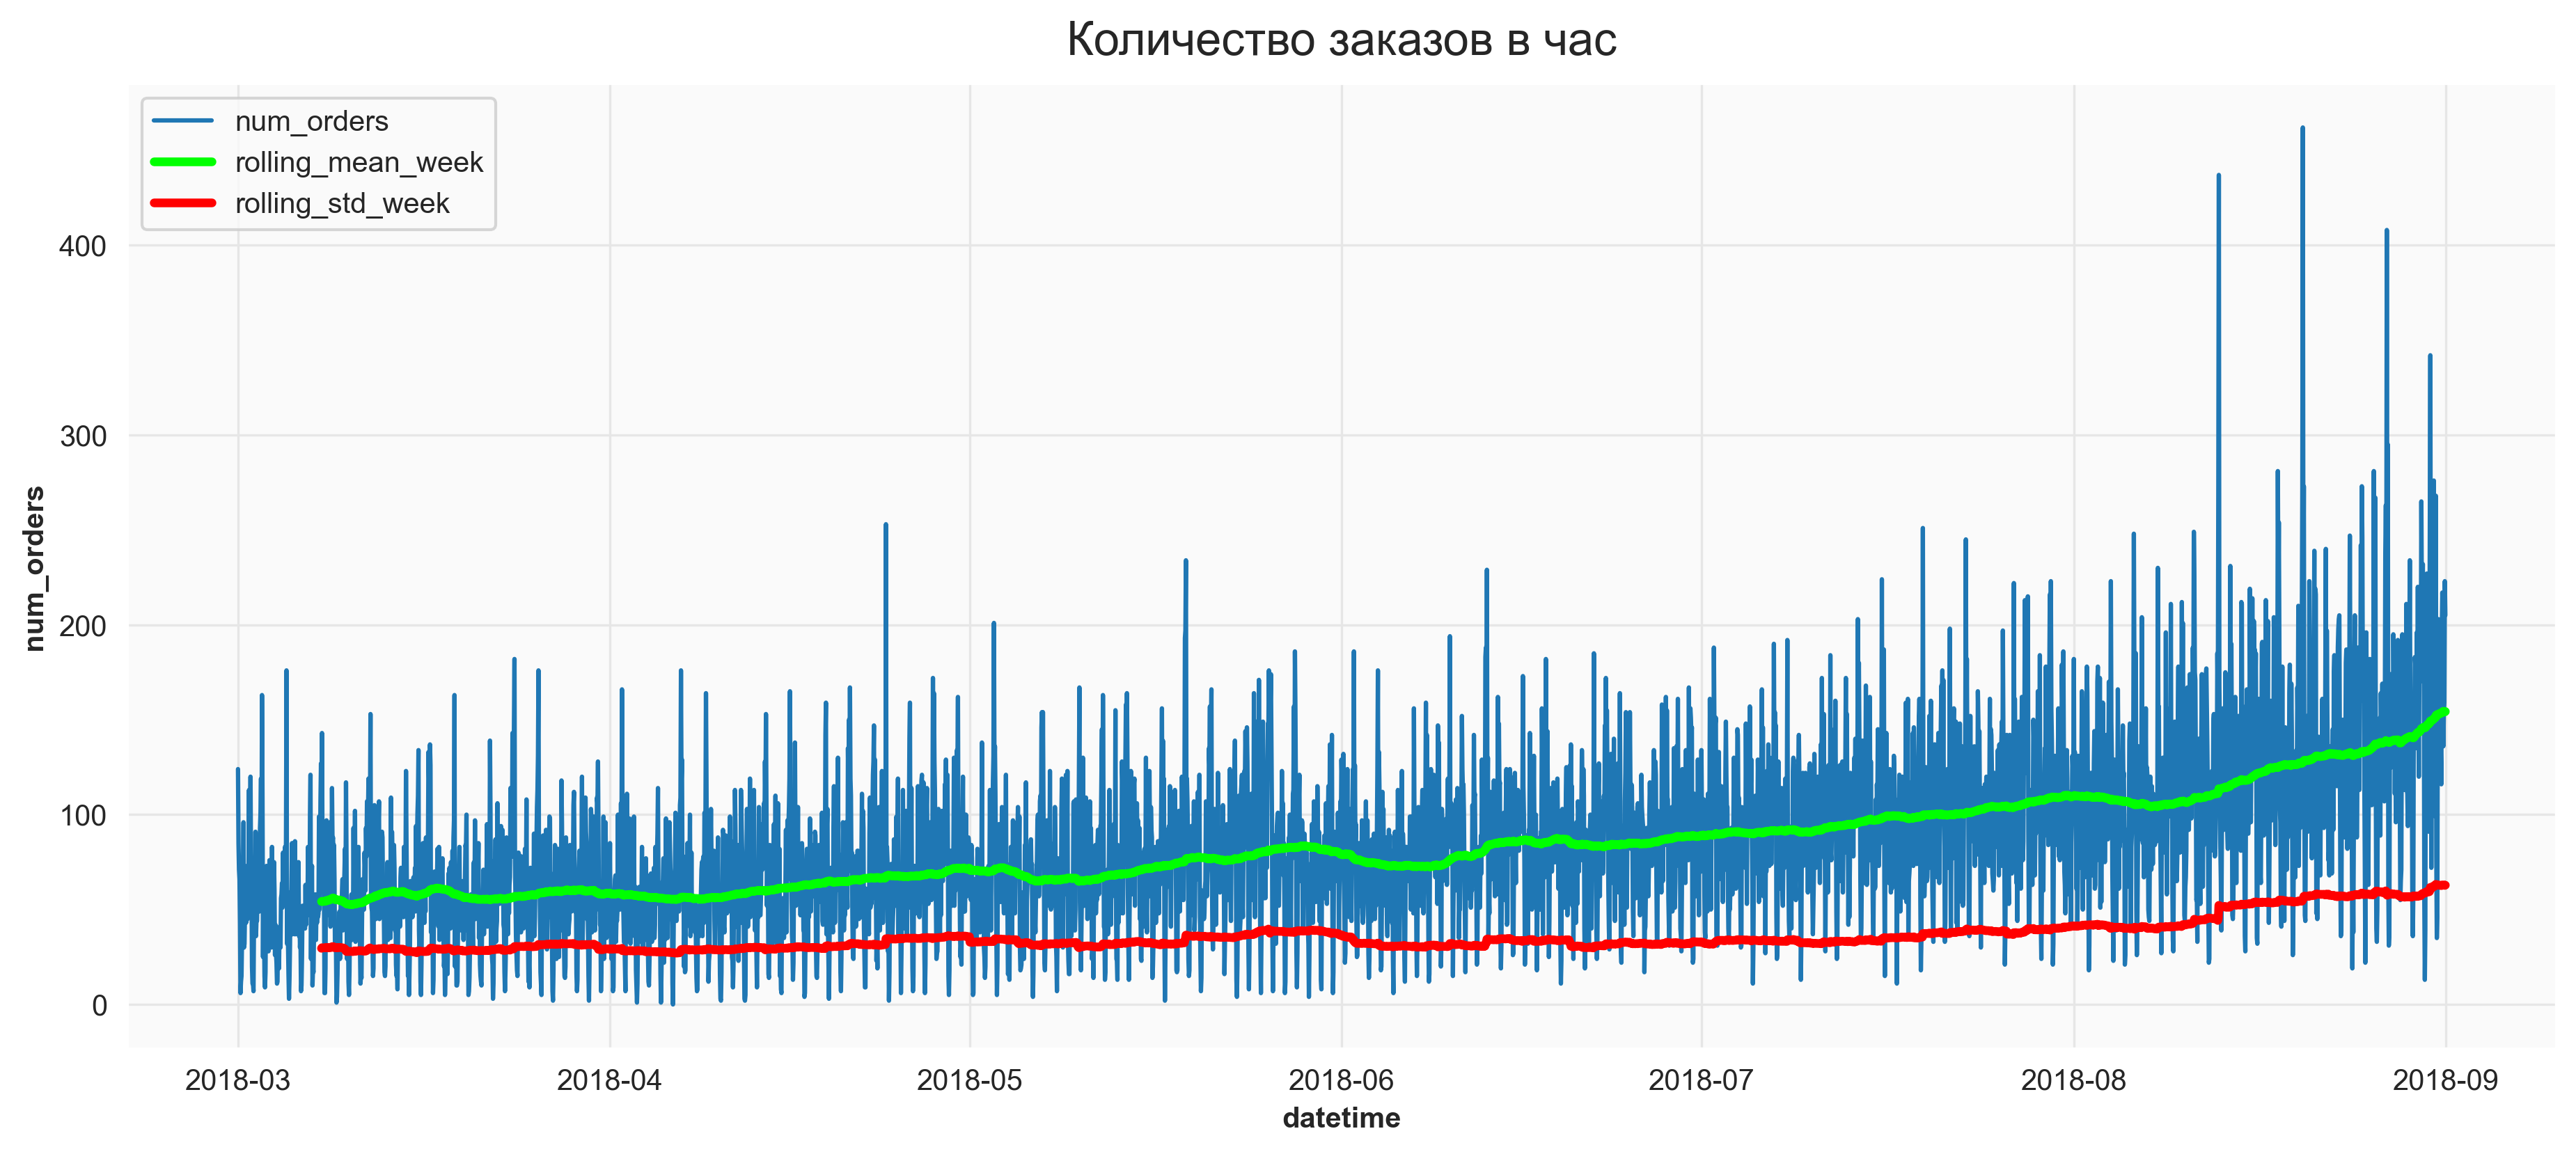

In [605]:
df = data.reset_index().copy()
df['rolling_mean_week'] = df.num_orders.rolling(24*7).mean()
df['rolling_std_week'] = df.num_orders.rolling(24*7).std()

fig, ax = plt.subplots(figsize=(15,6), dpi=PLOT_DPI)
sns.lineplot(data=df, x='datetime', y='num_orders', estimator=None, linewidth=1.5)
sns.lineplot(data=df, x='datetime', y='rolling_mean_week', estimator=None, linewidth=3, color='lime')
sns.lineplot(data=df, x='datetime', y='rolling_std_week', estimator=None, linewidth=3, color='red')

plt.title('Количество заказов в час')
plt.legend(['num_orders', 'rolling_mean_week', 'rolling_std_week']);

> 7-дневное скользящее среднее имеет легкий растущий тренд с ускорением в конце.
>
> Стандартное отклонение относительно стабильно, но в конце периода увеличивается.
>
> Ввиду наличия тренда, временной ряд не выглядит стационарным.

> Заметное отличие находится в конце временного ряда, и поэтому тестовая выборка будет заметно отличаться от обучающей. Это наверняка скажется на точности прогноза.

### Тренд и цикличность

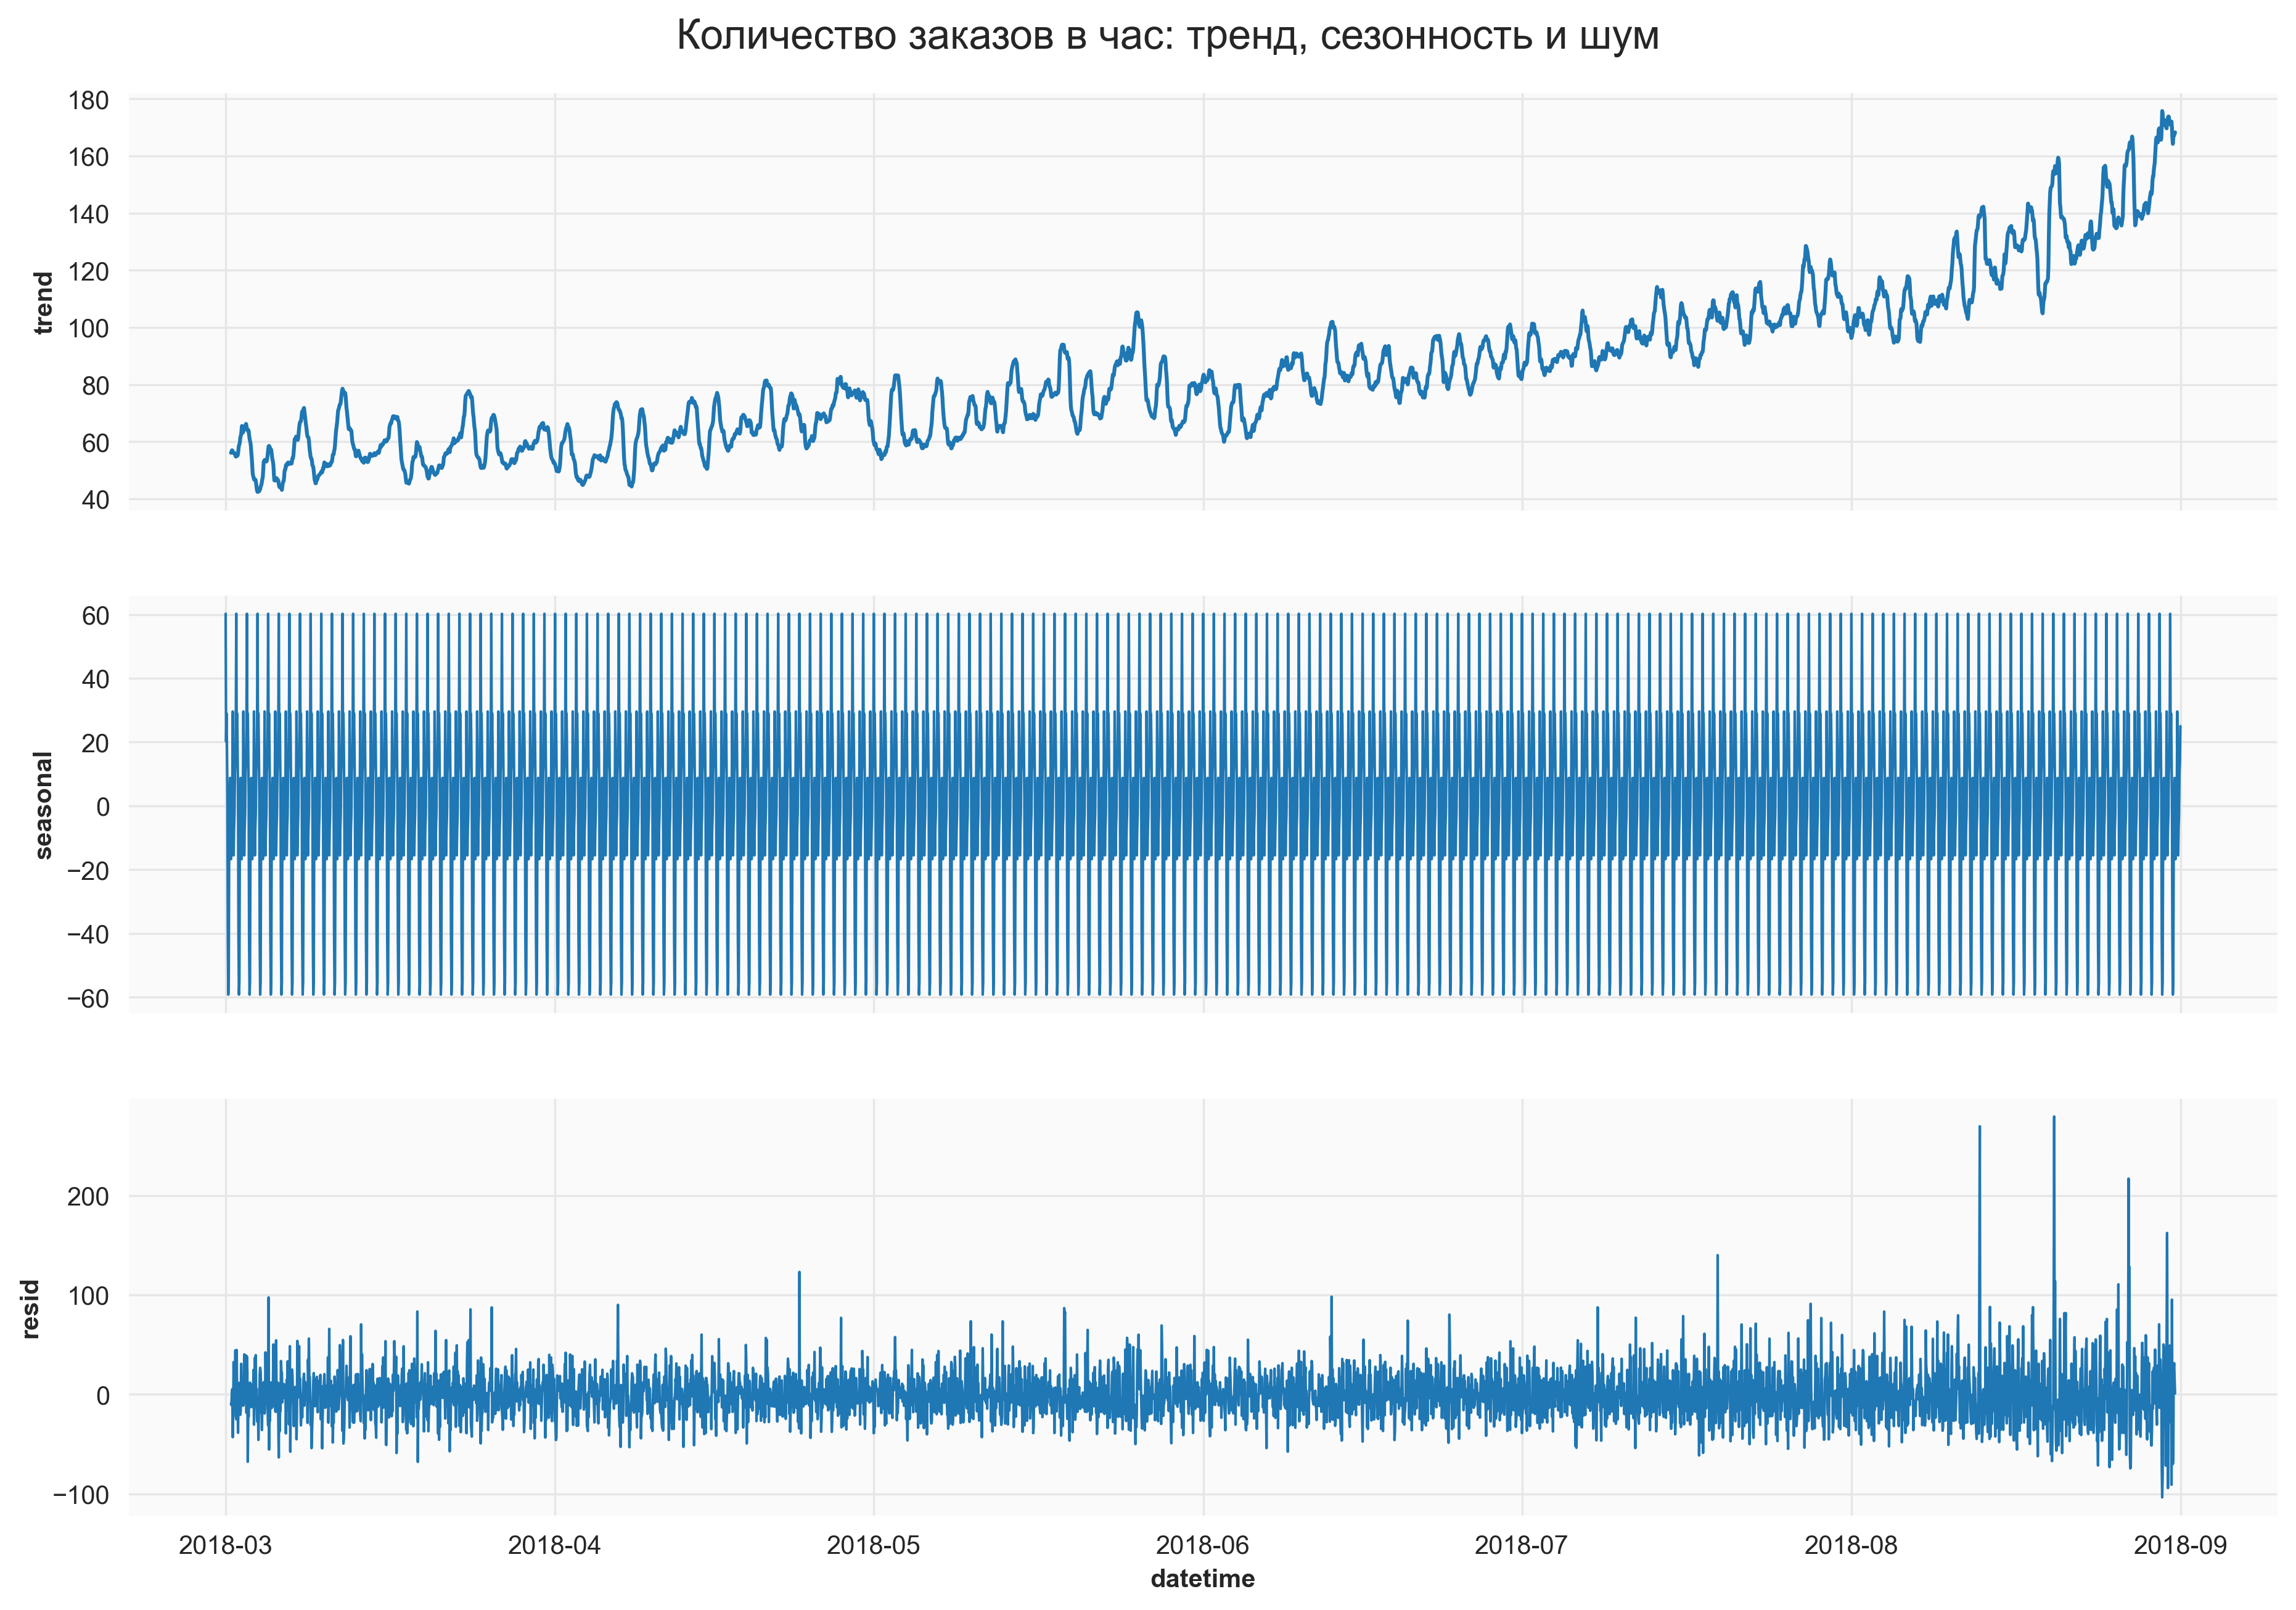

In [606]:
df = seasonal_decompose(data)

fig, ax = plt.subplots(figsize=(15,10), dpi=PLOT_DPI, nrows=3, sharex=True)

sns.lineplot(data=df.trend, linewidth=1.5, ax=ax[0])
sns.lineplot(data=df.seasonal, linewidth=1, ax=ax[1])
sns.lineplot(data=df.resid, linewidth=1, ax=ax[2])

plt.suptitle('Количество заказов в час: тренд, сезонность и шум', fontsize=16, y=0.92);

> Данные обработаны с помощью `seasonal_decompose` из библиотеки `statsmodels`.
>
> Подтверждено наличие растущего тренда. Поскольку представлены данные только за полгода, невозможно сделать вывод, связан ли этот тренд с временем года.
>
> Данные о суточной цикличности необходимо посмотреть при увеличенном масштабе.
>
> Шумы (residuals) усиливаются к концу рассматриваемого периода. Ими объясняются несколько сильных выбросов как вверх, так и вниз.

Укрупненный график цикличности за суточный период.

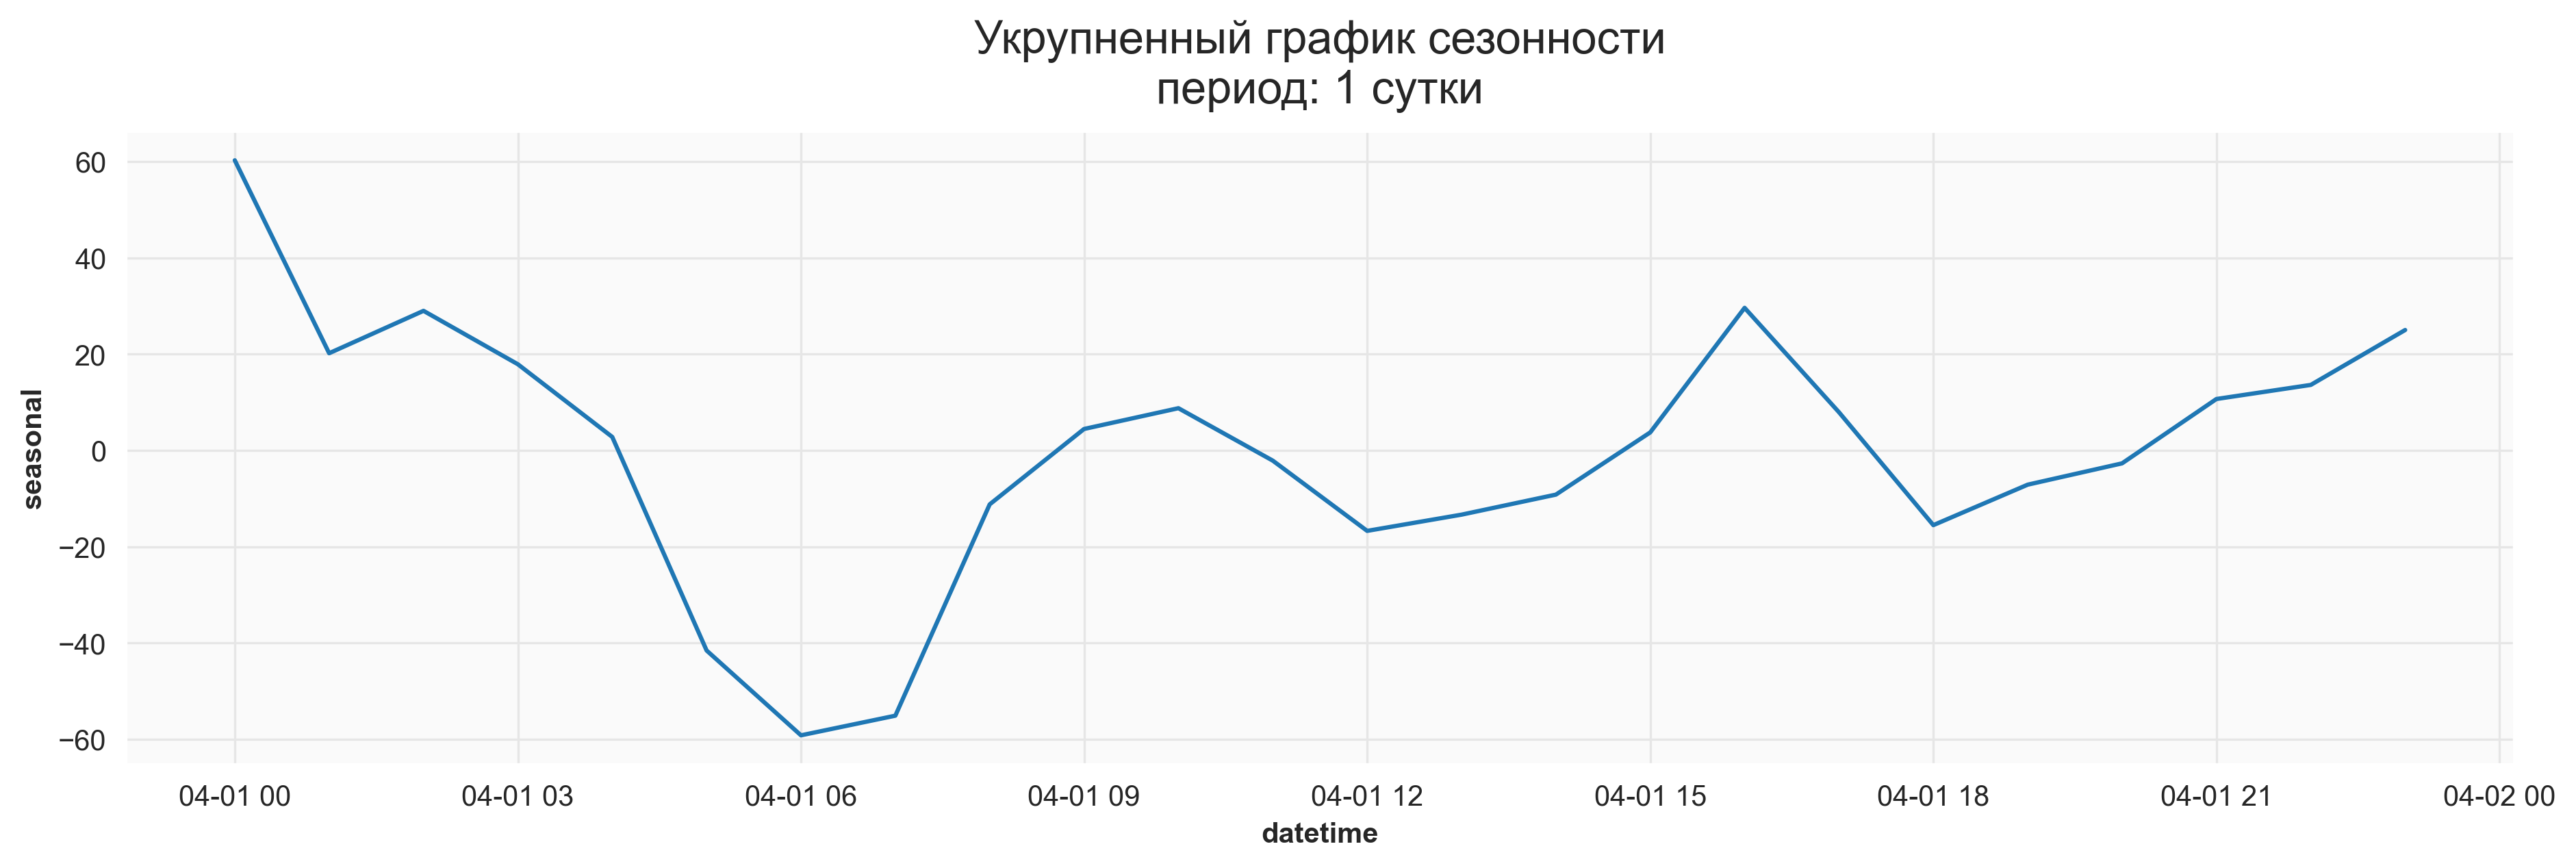

In [607]:
fig, ax = plt.subplots(figsize=(15,4), dpi=PLOT_DPI)

sns.lineplot(data=df.seasonal['2018-04-01':'2018-04-01'])
plt.title(f'Укрупненный график сезонности{CR}период: 1 сутки');

> На укрупненном графике сезонности видно распределение суточного спроса по часовым интервалам.  
> Наибольший спрос в 0 часов (фактически в период с 0 до 1 часа ночи), наименьший — с 5 до 8 утра.

### Стационарность временного ряда

> Наличие тренда говорит о нестационарности временного ряда.  
> Для более точной оценки стационарности применим тест Дики-Фуллера.
>
> В данном случае гипотезы звучат следующим образом:  
> - нулевая гипотеза предполагает, что процесс нестационарный;
> - альтернативная гипотеза говорит об обратном: ряд стационарный.
>
> Пороговое значение примен равным 0.05.

In [608]:
adfuller(data.num_orders)[1]

0.028940051402612847

> Полученное значение p-value меньше выбранного порога, однако недостаточно убедительно, чтобы с уверенностью можно было признать этот временной ряд стационарным.  
> К тому же, основное возмущение ряда находится в его конце — как раз эта часть попадет в тестовую выборку.

> Попробуем получить стационарный временной ряд, используя разность.

### Разность временного ряда

In [609]:
def plot_diff(diff_period_name, rolling_period=50, annot=''):
    '''
    Выводит скользящее среднее и стандартное отклонение для разности временного ряда.
    diff_period_name: название колонки в датафрейме, содержащей разность
    rolling_period: период окна для скользящих
    annot: строка для персонализации графика
    '''
    df['rolling_mean'] = df[diff_period_name].rolling(rolling_period).mean()
    df['rolling_std'] = df[diff_period_name].rolling(rolling_period).std()

    fig, ax = plt.subplots(figsize=(15,4), dpi=PLOT_DPI)
    sns.lineplot(data=df, x='datetime', y=diff_period_name, estimator=None, linewidth=0.5)
    sns.lineplot(data=df, x='datetime', y='rolling_mean', estimator=None, linewidth=2, color='lime')
    sns.lineplot(data=df, x='datetime', y='rolling_std', estimator=None, linewidth=2, color='red')

    ax.set_ylim(-100,100)
    plt.title(f'rolling_mean и rolling_std с периодом={rolling_period}{CR} для разности временного ряда{CR}{annot}')
    plt.legend([diff_period_name, 'rolling_mean', 'rolling_std']);

Расчет разностей.

In [610]:
df = data.reset_index().copy()

df['diff_hour'] = df.num_orders.diff()          # разность между соседними часами
df['diff_day'] = df.num_orders.diff(24)         # разность с интервалом в сутки (совпадает час)
df['diff_week'] = df.num_orders.diff(24*7)      # разность с интервалом в неделю (совпадает час и день недели)

Графики.

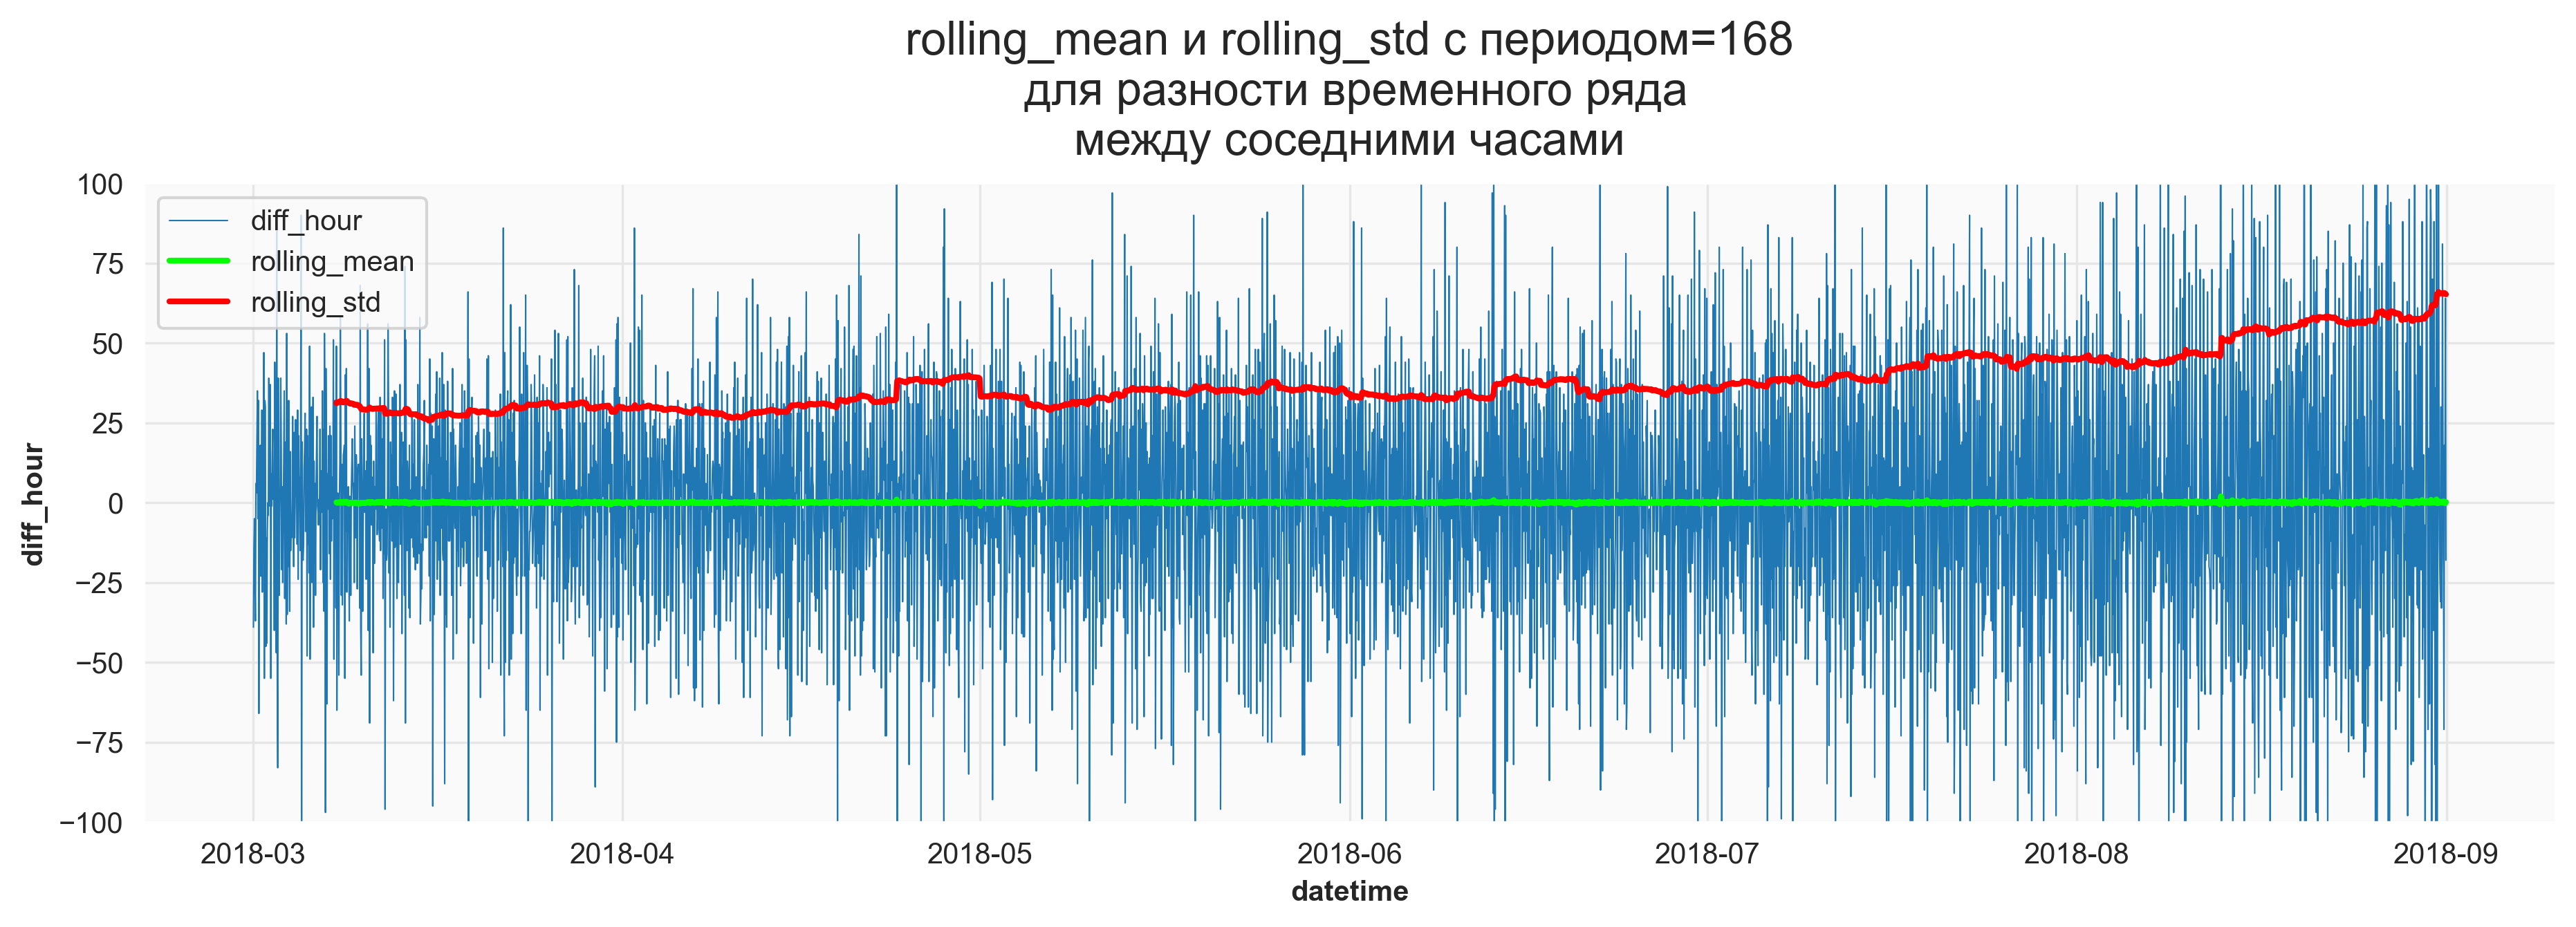

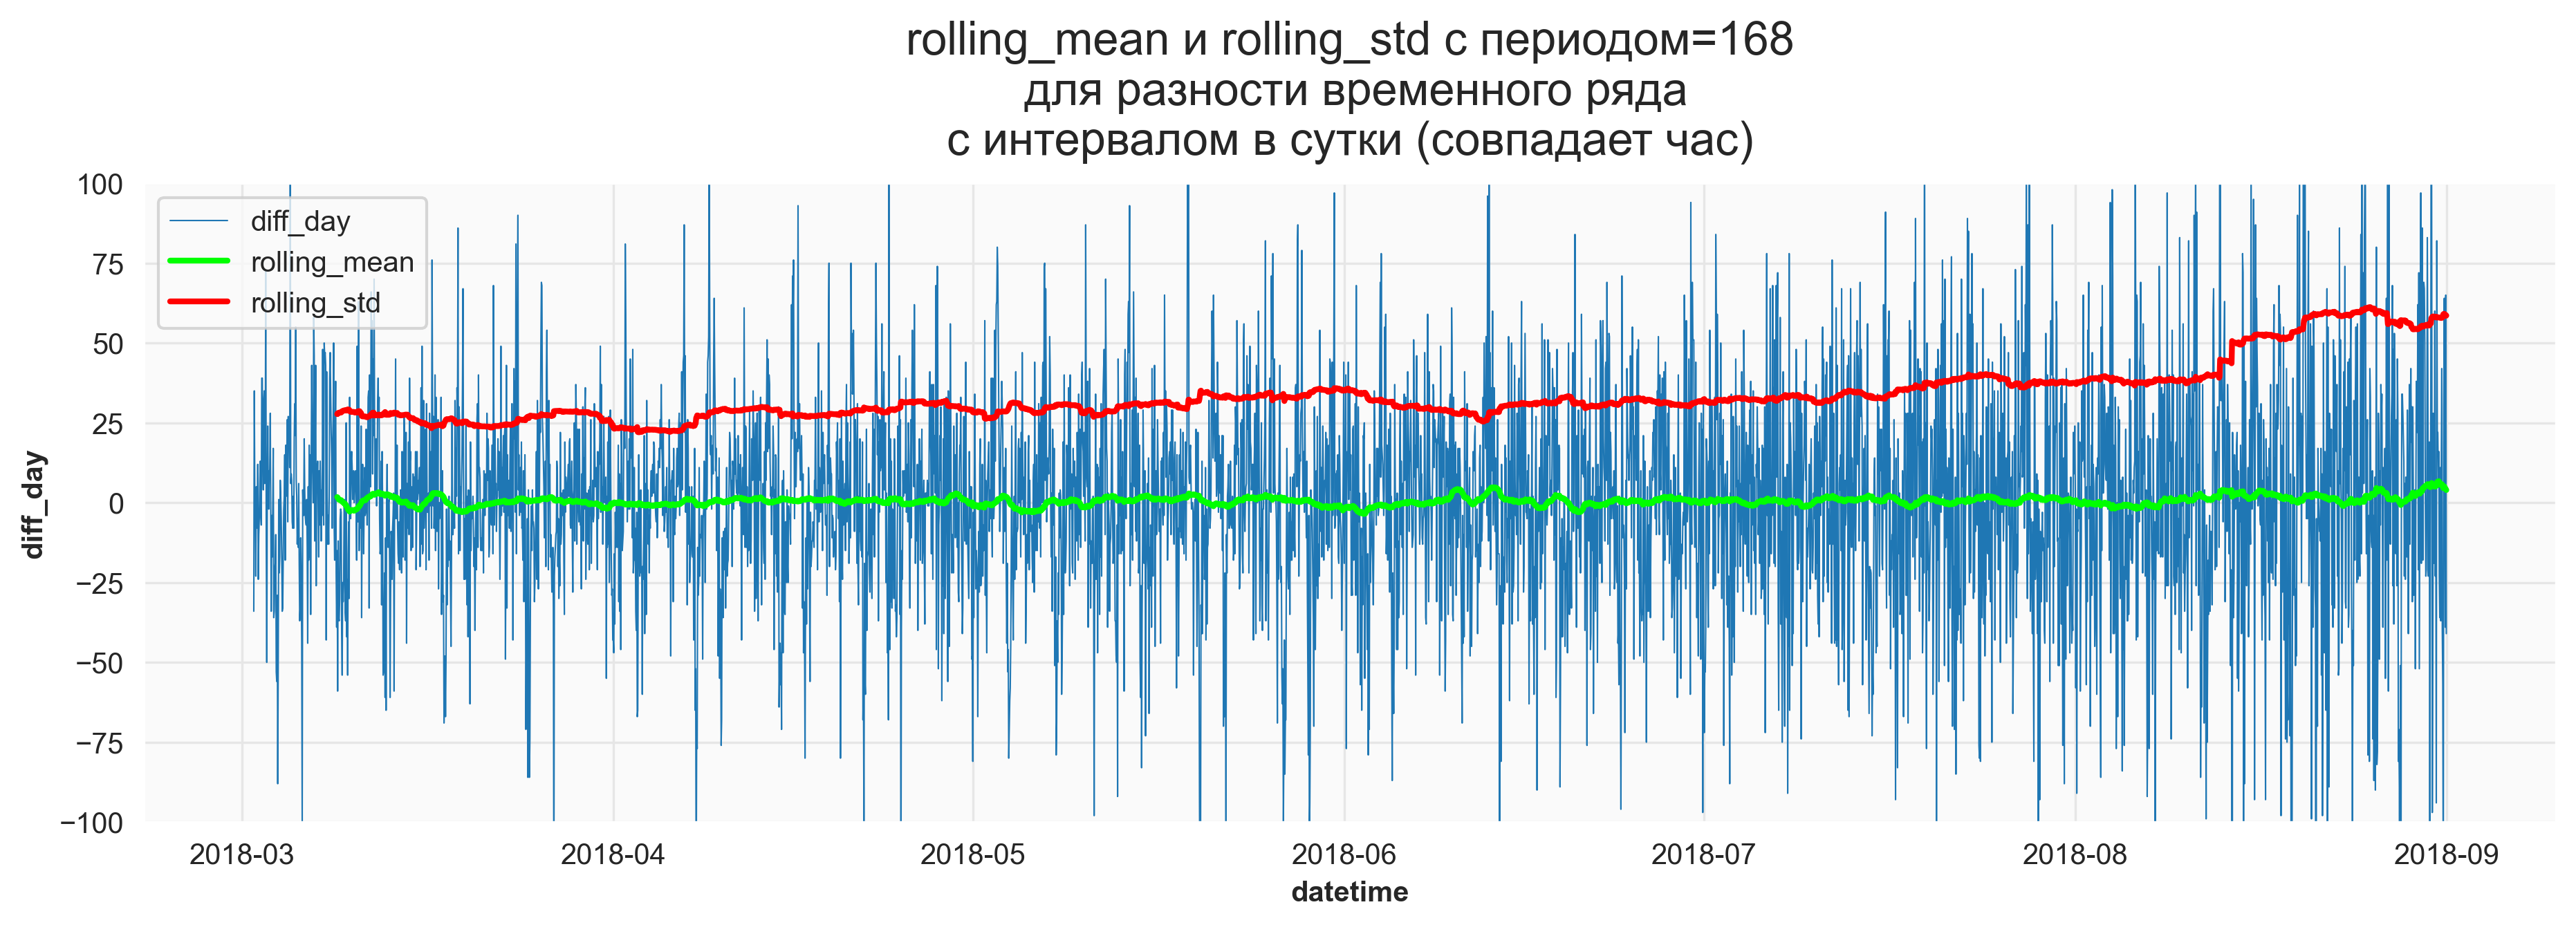

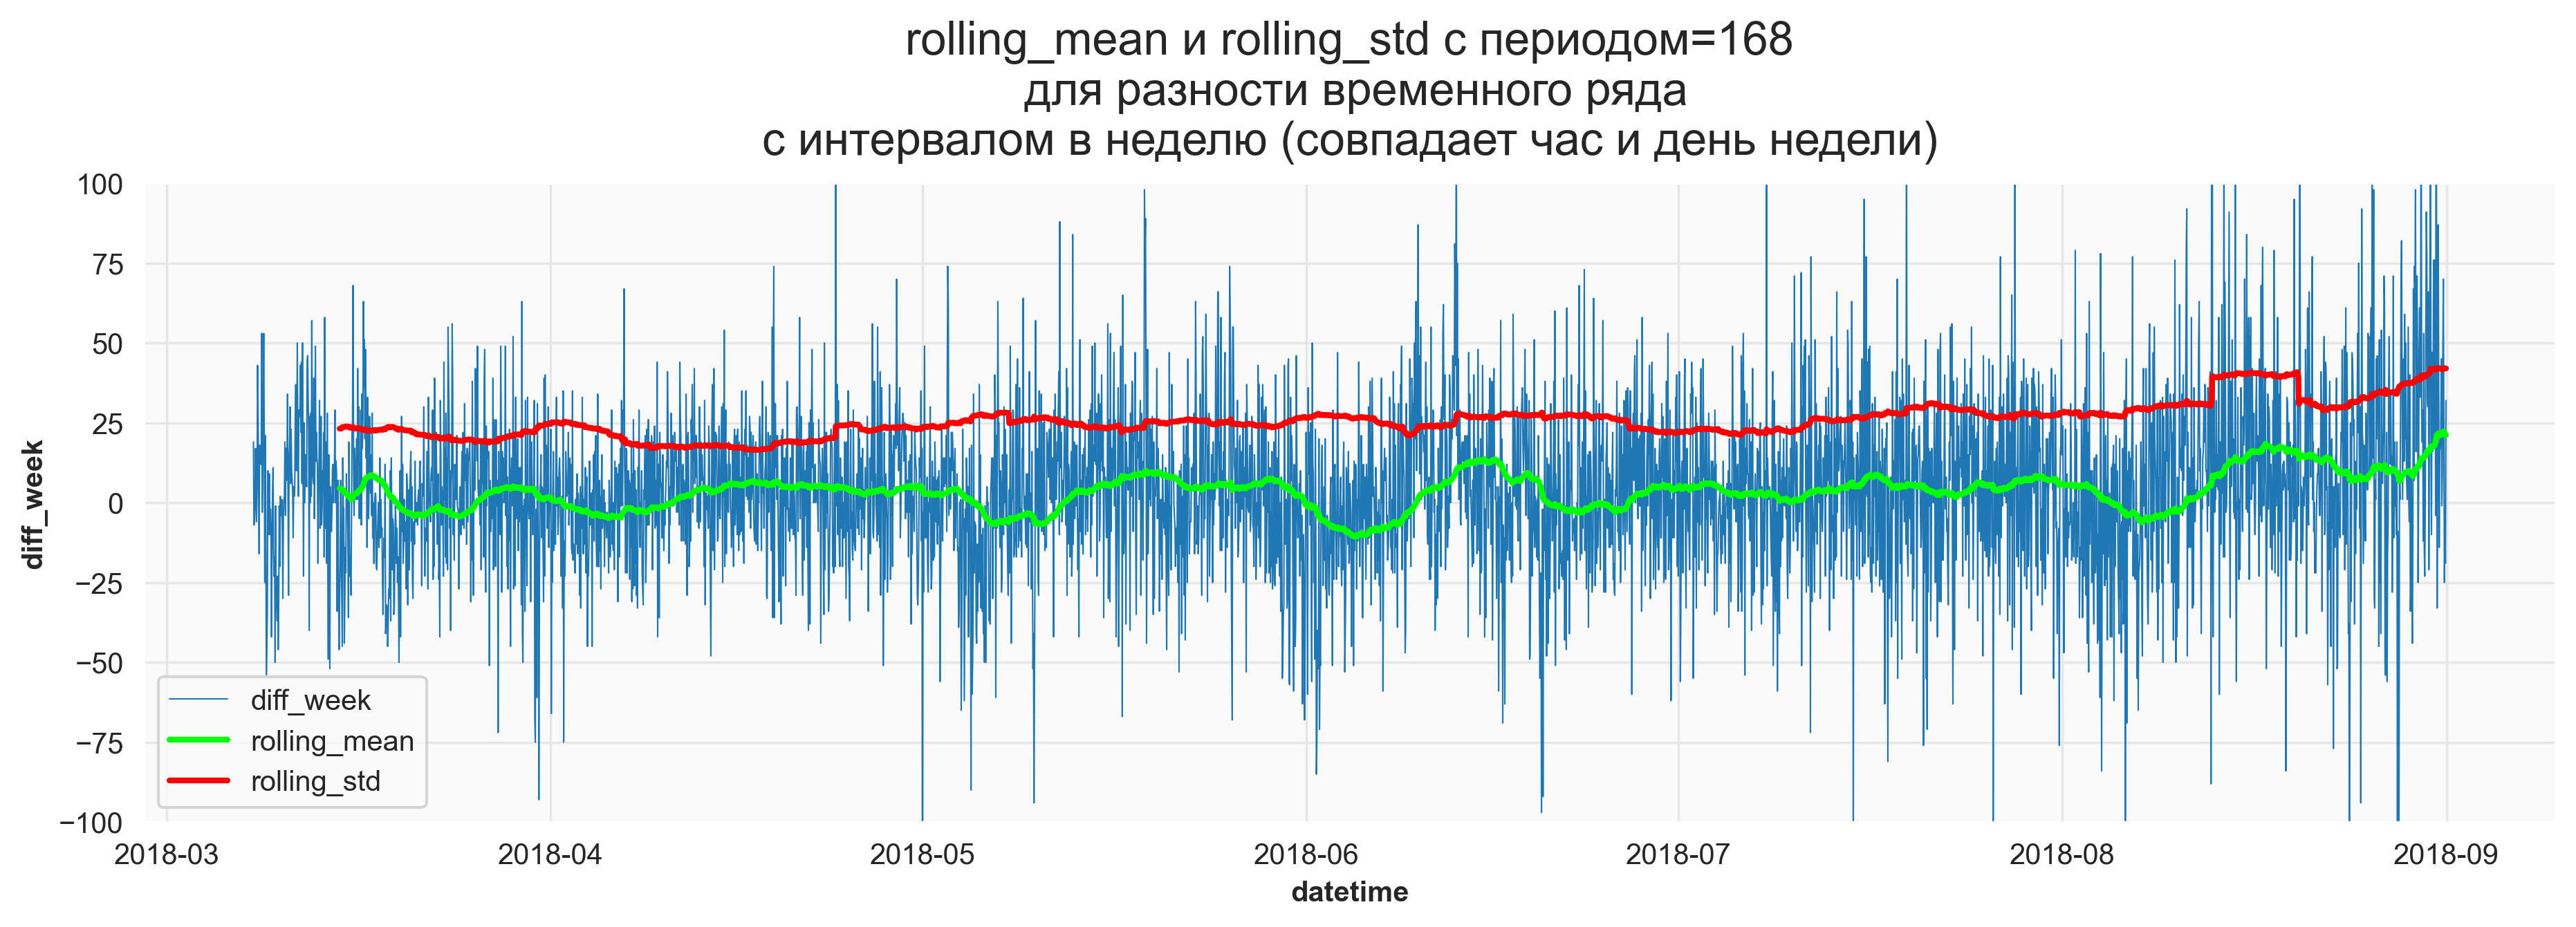

In [611]:
plot_diff('diff_hour', rolling_period=24*7, annot='между соседними часами')
plot_diff('diff_day', rolling_period=24*7, annot='с интервалом в сутки (совпадает час)')
plot_diff('diff_week', rolling_period=24*7, annot='с интервалом в неделю (совпадает час и день недели)')

> Сделана попытка получить стационарный временной ряд.  
> Исследованы скользящее среднее и стандартное отклонение для разности:
> - соседних значений (два соседних часа);
> - совпадающих значений часа с интервалом в сутки;
> - совпадающих значений часа и дня недели с интервалом в неделю.
>
> По внешнему виду трудно судить о стационарности полученных временных рядов.  
> Необхожимо применить тест Дики-Фуллера для оценки стационарности. P-value, нулевая и альтернативная гипотезы те же: 0.05, нестационарный, стационарный.

In [612]:
adfuller(df.dropna().diff_hour)[1]

4.620918277910728e-28

In [613]:
adfuller(df.dropna().diff_day)[1]

1.7808941904138443e-28

In [614]:
adfuller(df.dropna().diff_week)[1]

4.0989874615650845e-10

> P-value для всех трех временных рядов много ниже установленного порога и говорит о стационарности полученных временных рядов.

> *Стационарные ряды получил, но как применить их в модели — непонятно. В теории Практикума ни слова, поэтому продолжаю поиск примеров применения.*

### Автокорреляция

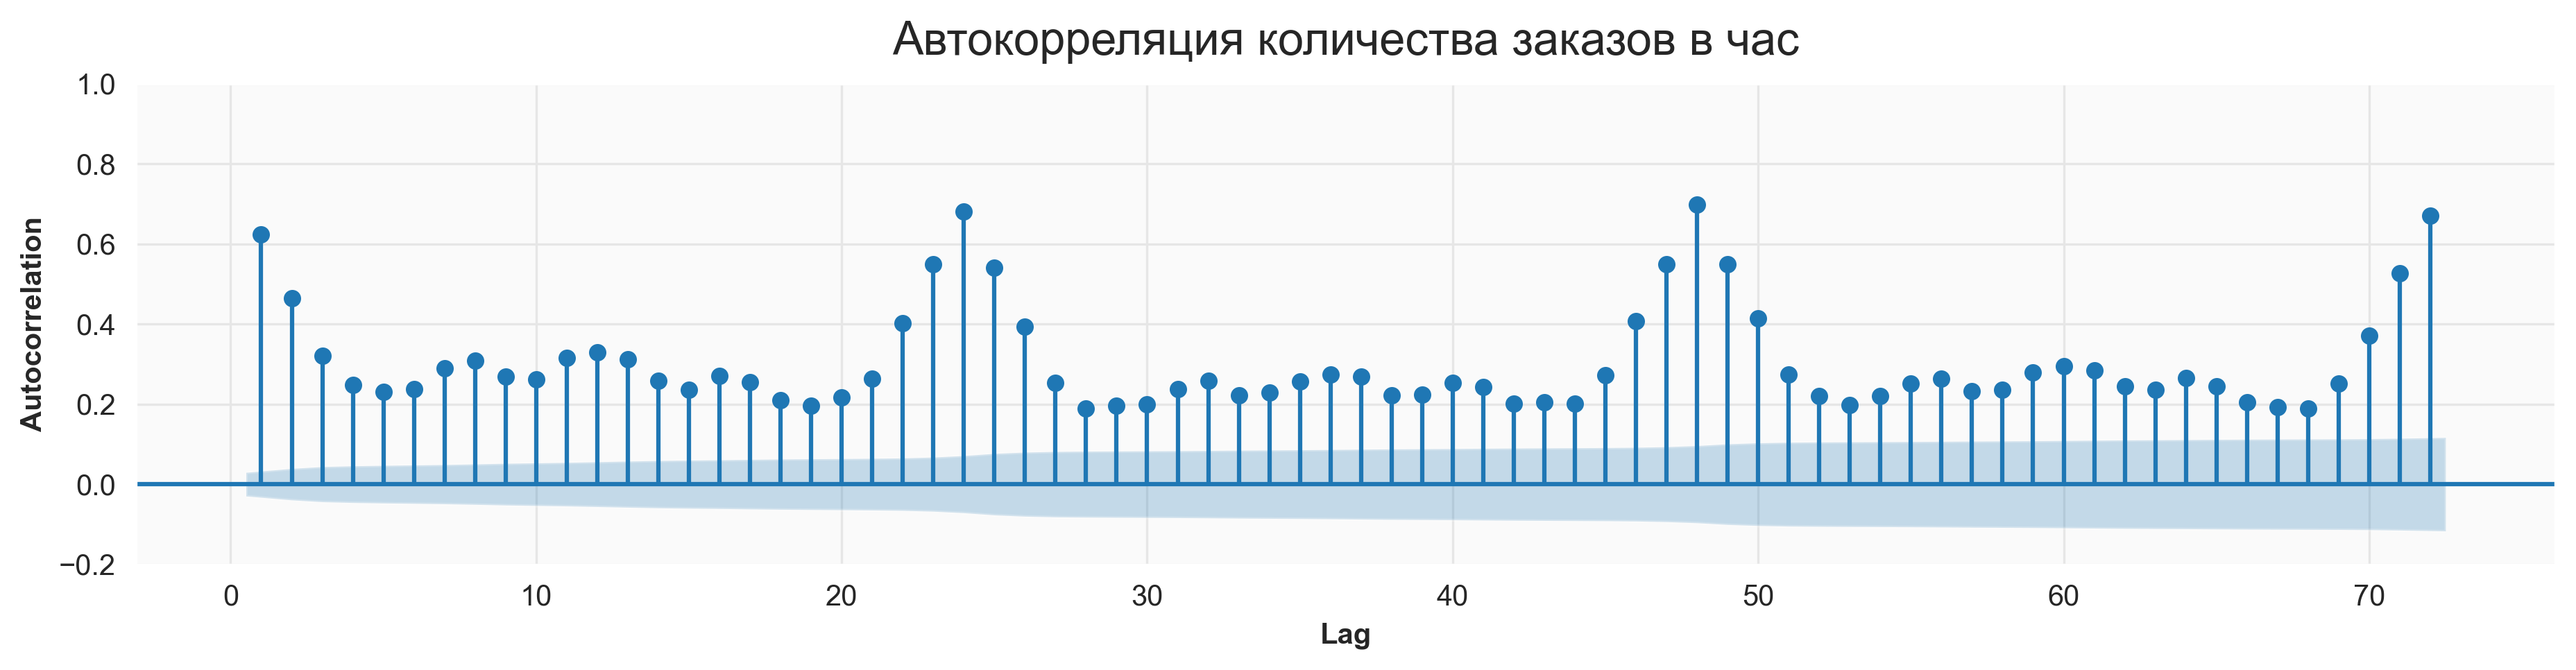

In [616]:
fig, ax = plt.subplots(figsize=(15,3), dpi=PLOT_DPI)

plot_acf(data.num_orders, ax=ax, lags=72, zero=False, title='Автокорреляция количества заказов в час')

ax.set_ylim(-0.2,)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation');

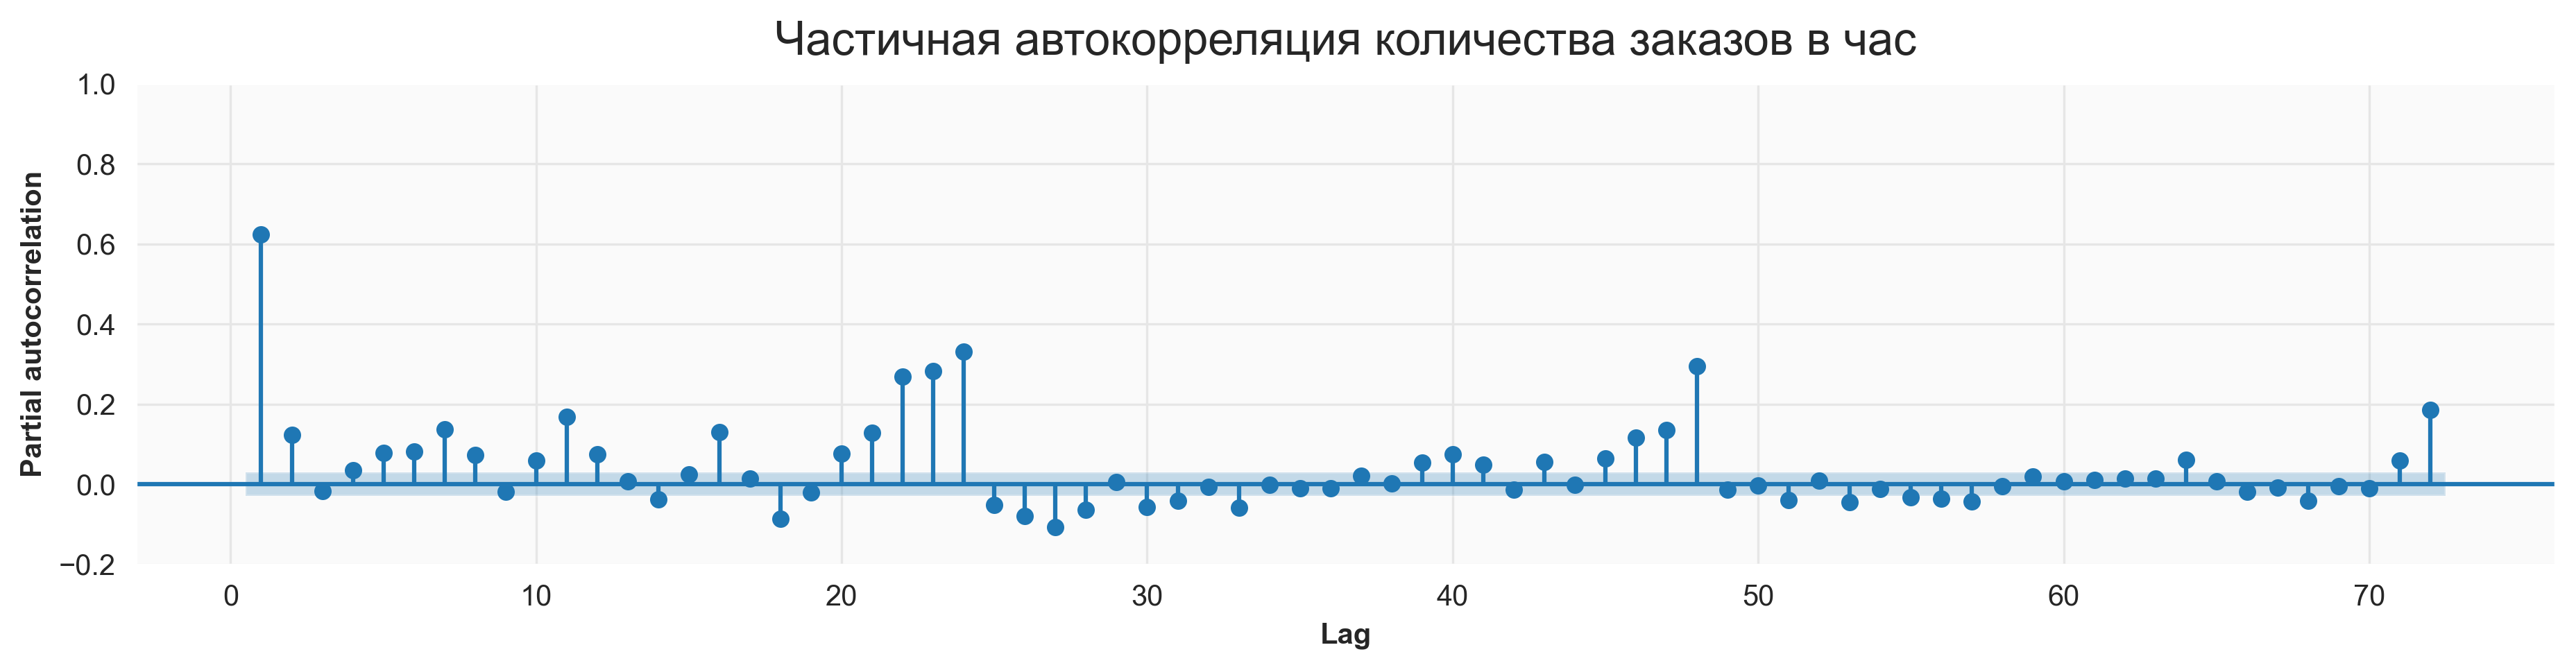

In [617]:
fig, ax = plt.subplots(figsize=(15,3), dpi=PLOT_DPI)

plot_pacf(data.num_orders, ax=ax, lags=72, zero=False, title='Частичная автокорреляция количества заказов в час')

ax.set_ylim(-0.2,)
ax.set_xlabel('Lag')
ax.set_ylabel('Partial autocorrelation');

> Автокорреляция подсказывает, что наиболее значимыми являются lag=1 и lag=24, то есть на количество заказов сильнее влияет количество заказов в предыдущий час и количество заказов в такой же час в другие дни.

---

## Model

### Подготовка данных

#### Feature engineering

Час и день недели.

In [618]:
data['hour'] = data.index.hour
data['weekday'] = data.index.dayofweek
# data['is_weekend'] = data.weekday.isin([5,6]) * 1        # бесполезен

Лаг.

In [619]:
max_lag = 72

for lag in range(1, max_lag + 1):
    data[f'lag_{lag}'] = data.num_orders.shift(lag)

Скользящее среднее.

In [620]:
window_size = [2, 3, 4, 6, 12, 18, 24]

for window in window_size:
    data[f'rolling_mean_{window}'] = data.num_orders.shift().rolling(window).mean()

In [621]:
data = data.dropna()

#### Выделение признаков и целевой переменной

In [622]:
X = data.drop(TARGET, axis=1)
Y = data[TARGET]

X.shape, Y.shape

((4344, 81), (4344,))

#### Разделение на обучающую и валидационную выборки

In [623]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=VALID_FRAC, shuffle=False, random_state=RS)

Размеры выборок.

In [624]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((3909, 81), (3909,), (435, 81), (435,))

Начальные и конечные значения индексов выборок (datetime).

In [625]:
X_train.index.min(), X_train.index.max()

(Timestamp('2018-03-04 00:00:00', freq='H'),
 Timestamp('2018-08-13 20:00:00', freq='H'))

In [626]:
X_valid.index.min(), X_valid.index.max()

(Timestamp('2018-08-13 21:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Упорядоченность индексов выборок.

In [627]:
X_train.index.is_monotonic_increasing, X_valid.index.is_monotonic_increasing

(True, True)

### Preprocessing

#### Селекторы числовых и категориальных признаков

In [628]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_exclude='number')

#### Предбработка числовых признаков

In [629]:
num_preprocessor = make_pipeline(
                                 StandardScaler(),
#                                  SplineTransformer(),
                                )

#### Предбработка категориальных признаков

Раздельно для линейных моделей и моделей на базе деревьев.

In [630]:
# for linear models
cat_preprocessor_linr = OneHotEncoder(drop='first', handle_unknown='ignore')

# for tree models
cat_preprocessor_tree = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#### Объединение предобработки числовых и категориальных признаков

In [631]:
# for linear models
preprocessing_linr = make_column_transformer(
                                             (num_preprocessor, num_selector),
                                             (cat_preprocessor_linr, cat_selector),
                                             remainder='drop'
                                            )
# for tree models
preprocessing_tree = make_column_transformer(
                                             (num_preprocessor, num_selector),
                                             (cat_preprocessor_tree, cat_selector),
                                             remainder='drop'
                                            )

#### Pipelines' table

In [632]:
pipelines = [
             Pipeline([
                       ('preprocessing_linr', preprocessing_linr),
                       ('D', DummyRegressor())
                      ]),
    
             Pipeline([
                       ('preprocessing_tree', preprocessing_tree),
                       ('RF', RandomForestRegressor(random_state=RS))
                      ]),
    
             Pipeline([
                       ('preprocessing_tree', preprocessing_tree),
                       ('XGB', XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=RS))
                      ]),
             Pipeline([
                       ('preprocessing_tree', preprocessing_tree),
                       ('LGBM', LGBMRegressor(force_row_wise=True, random_state=RS))
                  #      ('LGBM', DummyRegressor())                                      # заглушка для Windows_7
                      ]),
            ]

names = ['Dummy', 'RandomForest', 'XGBoost', 'LightGBM']

short_names = ['D', 'RF', 'XGB', 'LGBM']

models = pd.DataFrame(
                      data={'name': names,
                            'short_name': short_names,
                            'model': pipelines,
                           },
                     )
models

name          short_name  \
0         Dummy     D        
1  RandomForest    RF        
2       XGBoost   XGB        
3      LightGBM  LGBM        

  model                                                                                                 
0  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...  
1  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...  
2  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...  
3  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...

В таблице моделей необходимо оставить только те, что есть в списке ESTIMATOR_LIST (то есть удалить лишние).

In [633]:
for item in range(models.shape[0]):
    if models.loc[item,'name'] not in ESTIMATOR_LIST:
        models = models.drop(item, axis=0)
        
models = models.reset_index(drop=True)

models

name      short_name  \
0     Dummy     D        
1   XGBoost   XGB        
2  LightGBM  LGBM        

  model                                                                                                 
0  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...  
1  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...  
2  (ColumnTransformer(transformers=[('pipeline',\n                                 Pipeline(steps=[...

### Подбор гиперпараметров

#### Objective functions для Optuna

In [634]:
def objective_D(trial):

    params = {
              'D__strategy': trial.suggest_categorical('D__strategy', ['mean','median','quantile']),
              'D__quantile': trial.suggest_float('D__quantile', 0.0, 1.0),
             }
    
    model.set_params(**params)
#     cv_SKF = StratifiedKFold(n_splits=N_CV)
    cv_TS = TimeSeriesSplit(n_splits=N_CV)
    
    return -cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_TS, n_jobs=-1).mean()

In [635]:
def objective_RF(trial):

    params = {
              'RF__n_estimators': trial.suggest_int('RF__n_estimators', 50, 1000, log=True),
              'RF__max_depth': trial.suggest_int('RF__max_depth', 1, 50),
             }
    
    model.set_params(**params)
#     cv_SKF = StratifiedKFold(n_splits=5)
    cv_TS = TimeSeriesSplit(n_splits=N_CV)
    
    return -cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_TS, n_jobs=-1).mean()

In [636]:
def objective_XGB(trial):

    params = {
              'XGB__max_depth': trial.suggest_int('XGB__max_depth', 1, 20),
              'XGB__n_estimators': trial.suggest_int('XGB__n_estimators', 10, 200, log=True),
              'XGB__subsample': trial.suggest_float('XGB__subsample', 0.3, 1.0),
              'XGB__scale_pos_weight': trial.suggest_float('XGB__scale_pos_weight', 0.3, 0.7),
              'XGB__learning_rate': trial.suggest_float('XGB__learning_rate', 0.01, 0.99),
              'XGB__gamma': trial.suggest_float('XGB__gamma', 0.1, 10, log=True),
              'XGB__min_child_weight': trial.suggest_float('XGB__min_child_weight', 0.1, 10, log=True),
              'XGB__lambda': trial.suggest_float('XGB__lambda', 0.1, 10, log=True),
             }
    
    model.set_params(**params)
#     cv_SKF = StratifiedKFold(n_splits=N_CV)
    cv_TS = TimeSeriesSplit(n_splits=N_CV)
    
    return -cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_TS, n_jobs=-1).mean()

In [637]:
def objective_LGBM(trial):

    params = {
              'LGBM__boosting_type': trial.suggest_categorical('LGBM__boosting_type', ['gbdt','dart','goss']),
              'LGBM__num_leaves': trial.suggest_int('LGBM__num_leaves', 100, 1000, log=True),
              'LGBM__max_depth': trial.suggest_int('LGBM__max_depth', 1, 50),
              'LGBM__n_estimators': trial.suggest_int('LGBM__n_estimators', 10, 200, log=True),
              'LGBM__learning_rate': trial.suggest_float('LGBM__learning_rate', 0.005, 0.2),
              'LGBM__subsample_for_bin': trial.suggest_int('LGBM__subsample_for_bin', 1e4, 1e6, log=True),
              'LGBM__reg_alpha': trial.suggest_float('LGBM__reg_alpha', 0.05, 10, log=True),
              'LGBM__reg_lambda': trial.suggest_float('LGBM__reg_lambda', 0, 1),
             }
    
    model.set_params(**params)
#     cv_SKF = StratifiedKFold(n_splits=5)
    cv_TS = TimeSeriesSplit(n_splits=N_CV)
    
    return -cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_TS, n_jobs=-1).mean()

#### Optuna call

In [638]:
for item in range(models.shape[0]):
    
    print('—' * 60)
    print(f"{CR}{models.loc[item,'name']} hyperparams tuning...")
    
    model = models.loc[item,'model']

    # создание объекта optuna.study
    study = optuna.create_study(
                                study_name=models.loc[item,'name'],
                                direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=RS)
                               )

    # оптимизация (подбор гиперпараметров)
    study.optimize(eval(f"objective_{models.loc[item,'short_name']}"),
                   n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)

    # извлечение и обучение лучшей модели – здесь можно сделать обучение на полном наборе данных (X,Y)
    model.set_params(**study.best_params).fit(X_train, Y_train)

    # сохранение результатов в таблице моделей
    models.loc[item,'model'] = model
    models.loc[item,'study'] = study
#     models.loc[item,'features'] = ', '.join(extract_final_features(model))   # пока недостаточно универсально
    models.loc[item,'score'] = study.best_value

    print(f'{CR}{f.BOLD}{study.study_name}{f.END}{CR}')
    print(f'Количество попыток: {len(study.trials)}')
    print(f'Лучший результат: {f.BOLD}{study.best_value:0.4f}{f.END}{CR}')
    print('Комбинация гиперпараметров:')
    print(json.dumps(study.best_params, indent=1, sort_keys=True), f'{CR}')

————————————————————————————————————————————————————————————

Dummy hyperparams tuning...


Best trial: 278. Best value: 35.4545: 100%|██████████| 300/300 [00:26<00:00, 11.38it/s, 26.35/600 seconds]



Dummy

Количество попыток: 300
Лучший результат: 35.4545

Комбинация гиперпараметров:
{
 "D__quantile": 0.7034721656113533,
 "D__strategy": "quantile"
} 

————————————————————————————————————————————————————————————

XGBoost hyperparams tuning...


Best trial: 264. Best value: 22.1129:  88%|████████▊ | 265/300 [11:24<01:30,  2.58s/it, 684.22/600 seconds]



XGBoost

Количество попыток: 265
Лучший результат: 22.1129

Комбинация гиперпараметров:
{
 "XGB__gamma": 1.4028537911855758,
 "XGB__lambda": 1.2348785733364604,
 "XGB__learning_rate": 0.03521870374267848,
 "XGB__max_depth": 7,
 "XGB__min_child_weight": 6.2312879624092,
 "XGB__n_estimators": 198,
 "XGB__scale_pos_weight": 0.3537172214988525,
 "XGB__subsample": 0.7151652216465194
} 

————————————————————————————————————————————————————————————

LightGBM hyperparams tuning...


Best trial: 175. Best value: 22.1361:  67%|██████▋   | 200/300 [11:09<05:34,  3.35s/it, 669.24/600 seconds]



LightGBM

Количество попыток: 200
Лучший результат: 22.1361

Комбинация гиперпараметров:
{
 "LGBM__boosting_type": "gbdt",
 "LGBM__learning_rate": 0.06761008423202236,
 "LGBM__max_depth": 35,
 "LGBM__n_estimators": 123,
 "LGBM__num_leaves": 381,
 "LGBM__reg_alpha": 5.497189772301402,
 "LGBM__reg_lambda": 0.5062279845926592,
 "LGBM__subsample_for_bin": 66547
} 



#### Визуализация результатов подбора гиперпараметров

Для корректировки процесса подбора.

In [639]:
# for item in range(models.shape[0]):
#     plot_Optuna(models.loc[item,'study'], 'plot_slice', models.loc[item, 'name'])
#     plot_Optuna(models.loc[item,'study'], 'plot_param_importances', models.loc[item, 'name'])
#     plot_Optuna(models.loc[item,'study'], 'plot_optimization_history', models.loc[item, 'name'])

## Анализ моделей

### Дополнительные метрики

В дополнение к основной метрике, полученной во время подбора гиперпараметров, можно сравнить метрики, рассчитанные с помощью кроссвалидации. Можно изменять параметры кроссвалидации.  
Метрики рассчитываются как для обучающей, так и валидационной выборки.

In [640]:
%%time
# дополнительные метрики моделей
models = add_model_metrics(models, X_train, Y_train, X_valid, Y_valid, cv=TimeSeriesSplit(n_splits=N_CV),
                           scoring_list=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'])

models.drop(['short_name','model','study','best_params'], axis=1).sort_values('score', ascending=True).reset_index(drop=True)

Performing cross_val_score with cv=20 and scoring_list=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']:
neg_root_mean_squared_error_train... done
neg_root_mean_squared_error_test... done
neg_mean_absolute_error_train... done
neg_mean_absolute_error_test... done
r2_train... done
r2_test... done
CPU times: total: 781 ms
Wall time: 43.6 s


name       score  neg_root_mean_squared_error_train  \
0   XGBoost 22.113 22.113                               
1  LightGBM 22.136 22.136                               
2     Dummy 35.455 35.455                               

   neg_root_mean_squared_error_test  neg_mean_absolute_error_train  \
0 41.035                            16.534                           
1 41.669                            16.622                           
2 58.671                            27.263                           

   neg_mean_absolute_error_test  r2_train  r2_test  
0 31.049                         0.580     0.381    
1 31.756                         0.577     0.365    
2 46.174                        -0.077    -0.241

> Чтобы лучше понимать качество модели, посчитаны несколько дополнительных метрик.
>
> Метрики на тестовой выборке заметно хуже, чем на обучающей. Вероятно, это связано с тем, что именно в конце временного периода наблюдается наибольшее нарушение стационарности временного ряда.
>
> Метрика R2 невысока, что в целом говорит о качестве модели.
>
> RMSE выше, чем MAE, поэтому можно предположить, что модель больше ошибается в точках, где значения сильно отклоняются от среднего.

### Выбор лучшей модели

In [641]:
SCORE_FIELD = 'score'      # название поля для выбора лучшей модели
LESS_IS_BETTER = True      # для направления сортировки

# название модели с лучшим score
best_model_name = models.sort_values(SCORE_FIELD, ascending=LESS_IS_BETTER).reset_index(drop=True).loc[0,'name']

# выбор модели из таблицы
model = models[models.name == best_model_name].model.values[0]

In [642]:
best_model_name

'XGBoost'

### RMSE модели на валидационной выборке

In [643]:
mean_squared_error(Y_valid, model.predict(X_valid), squared=False)

38.11217590336858

### Важность признаков

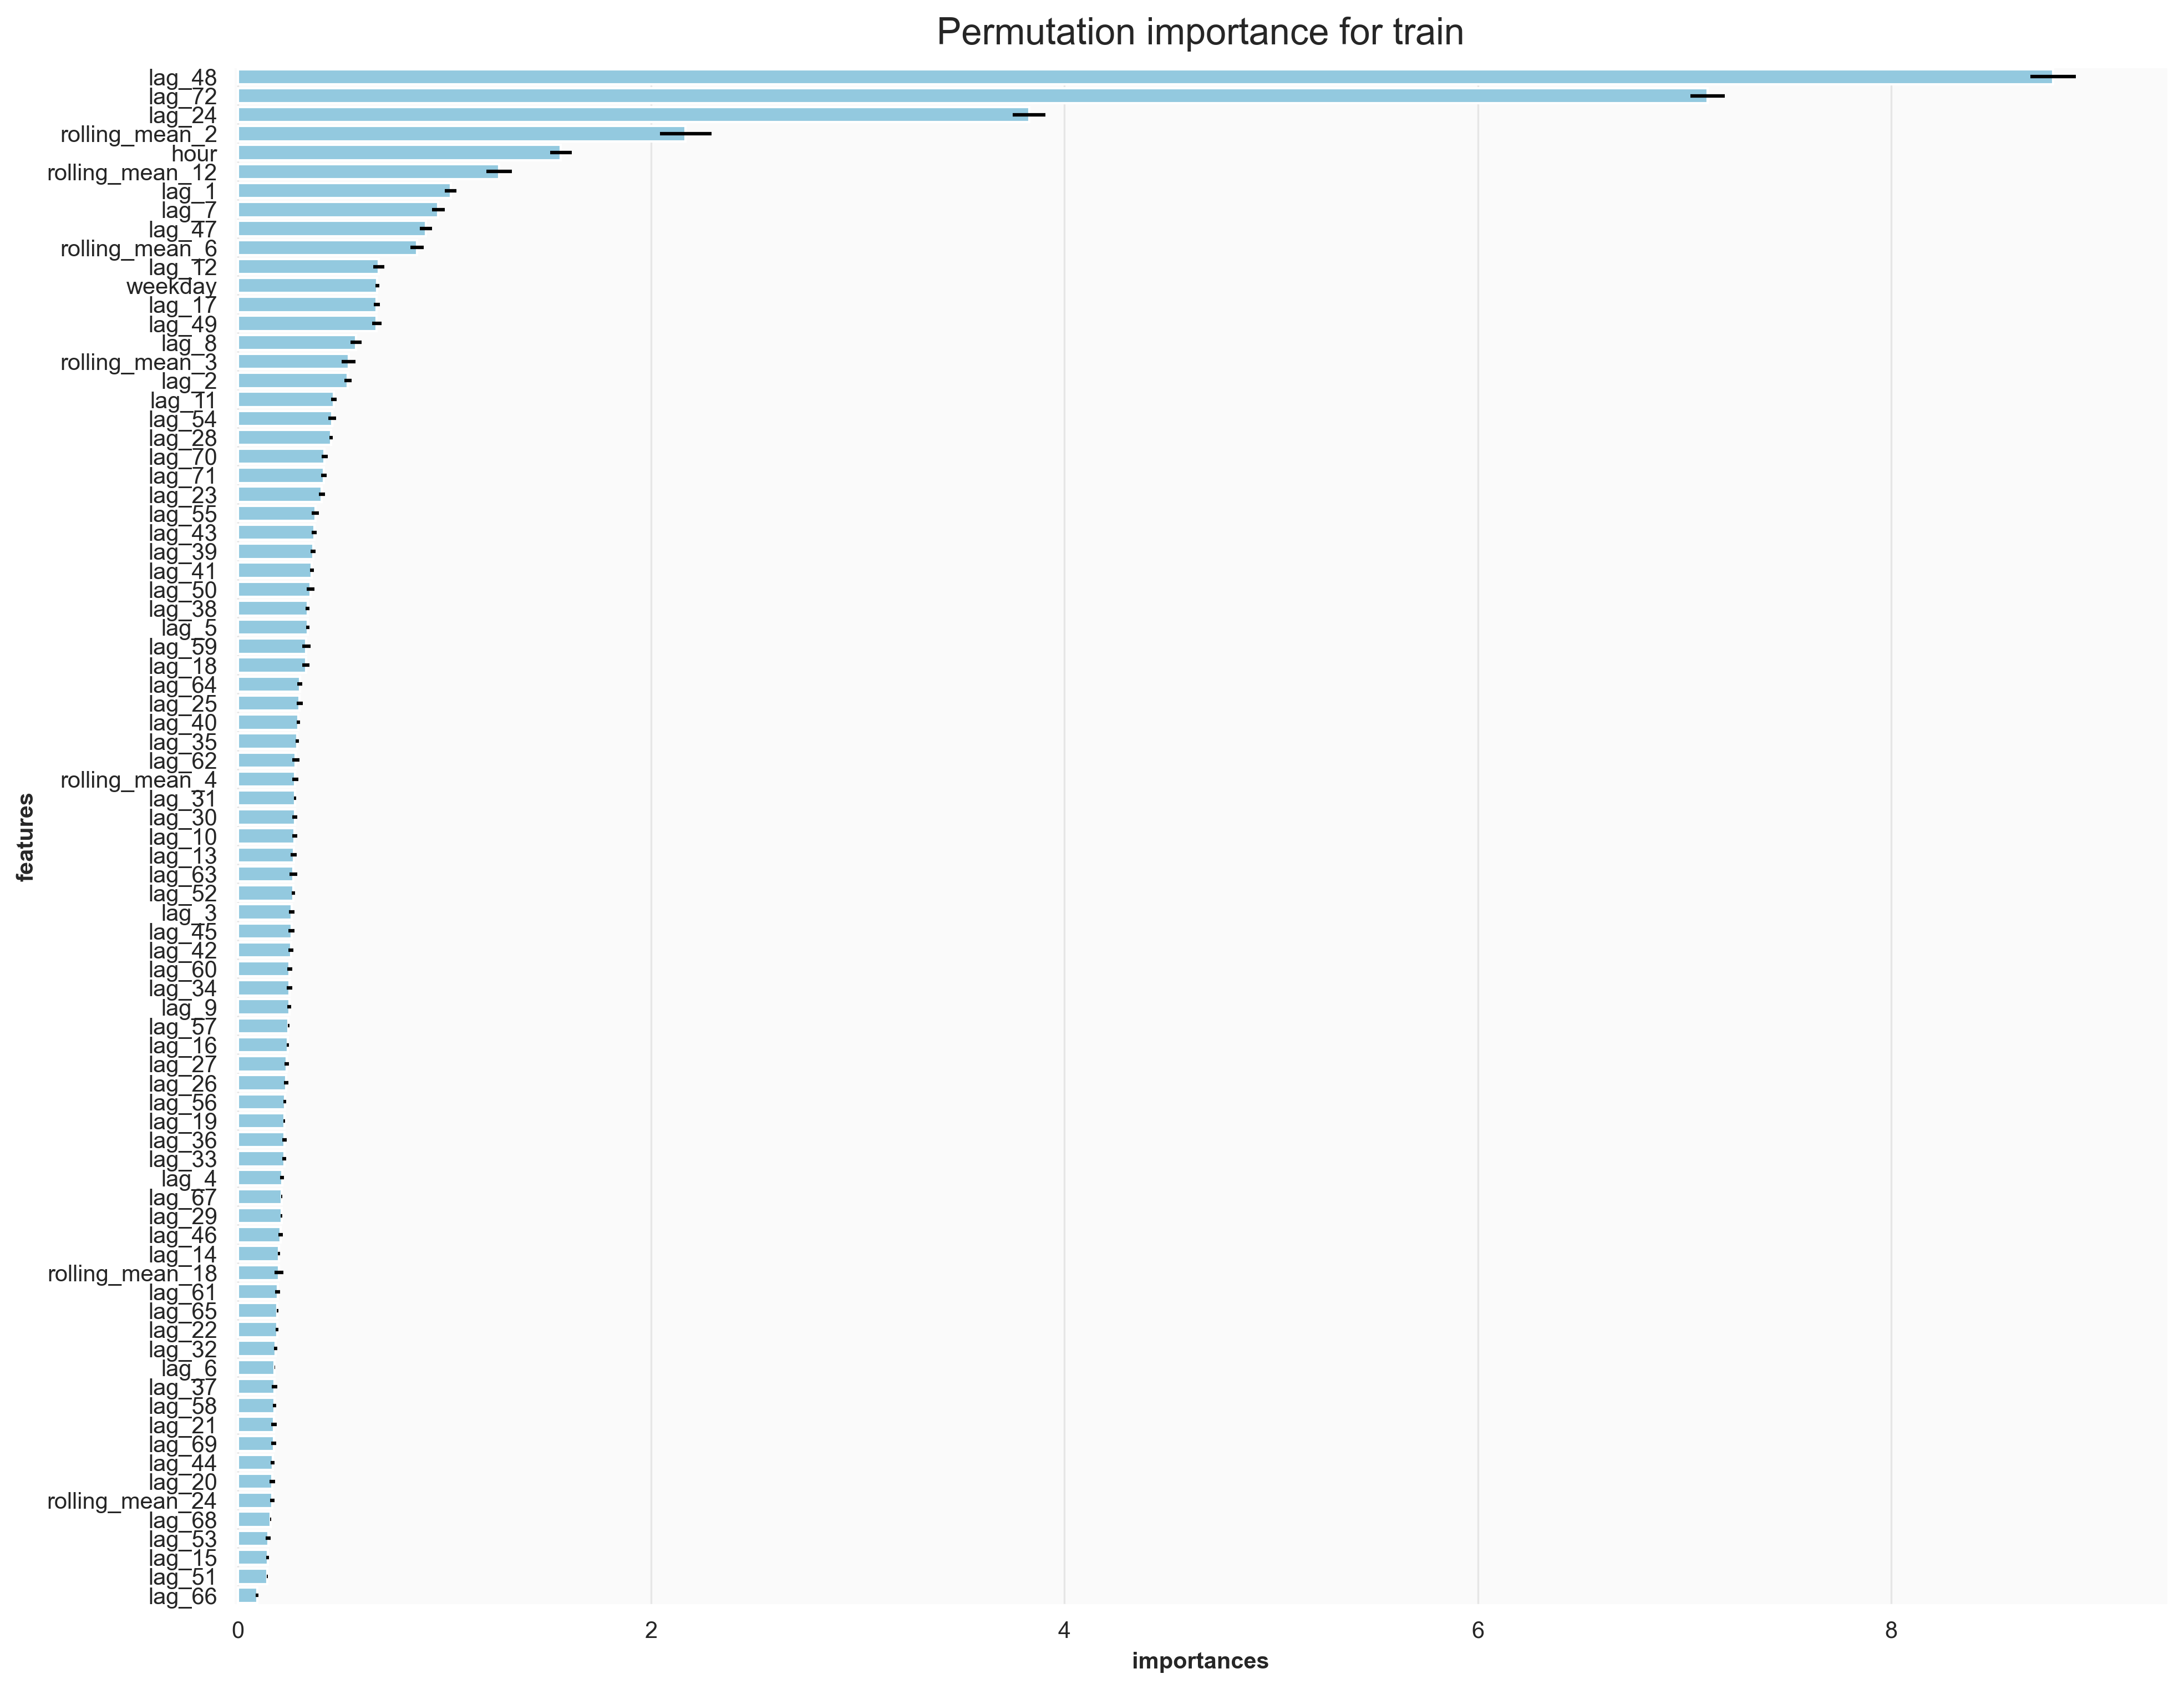

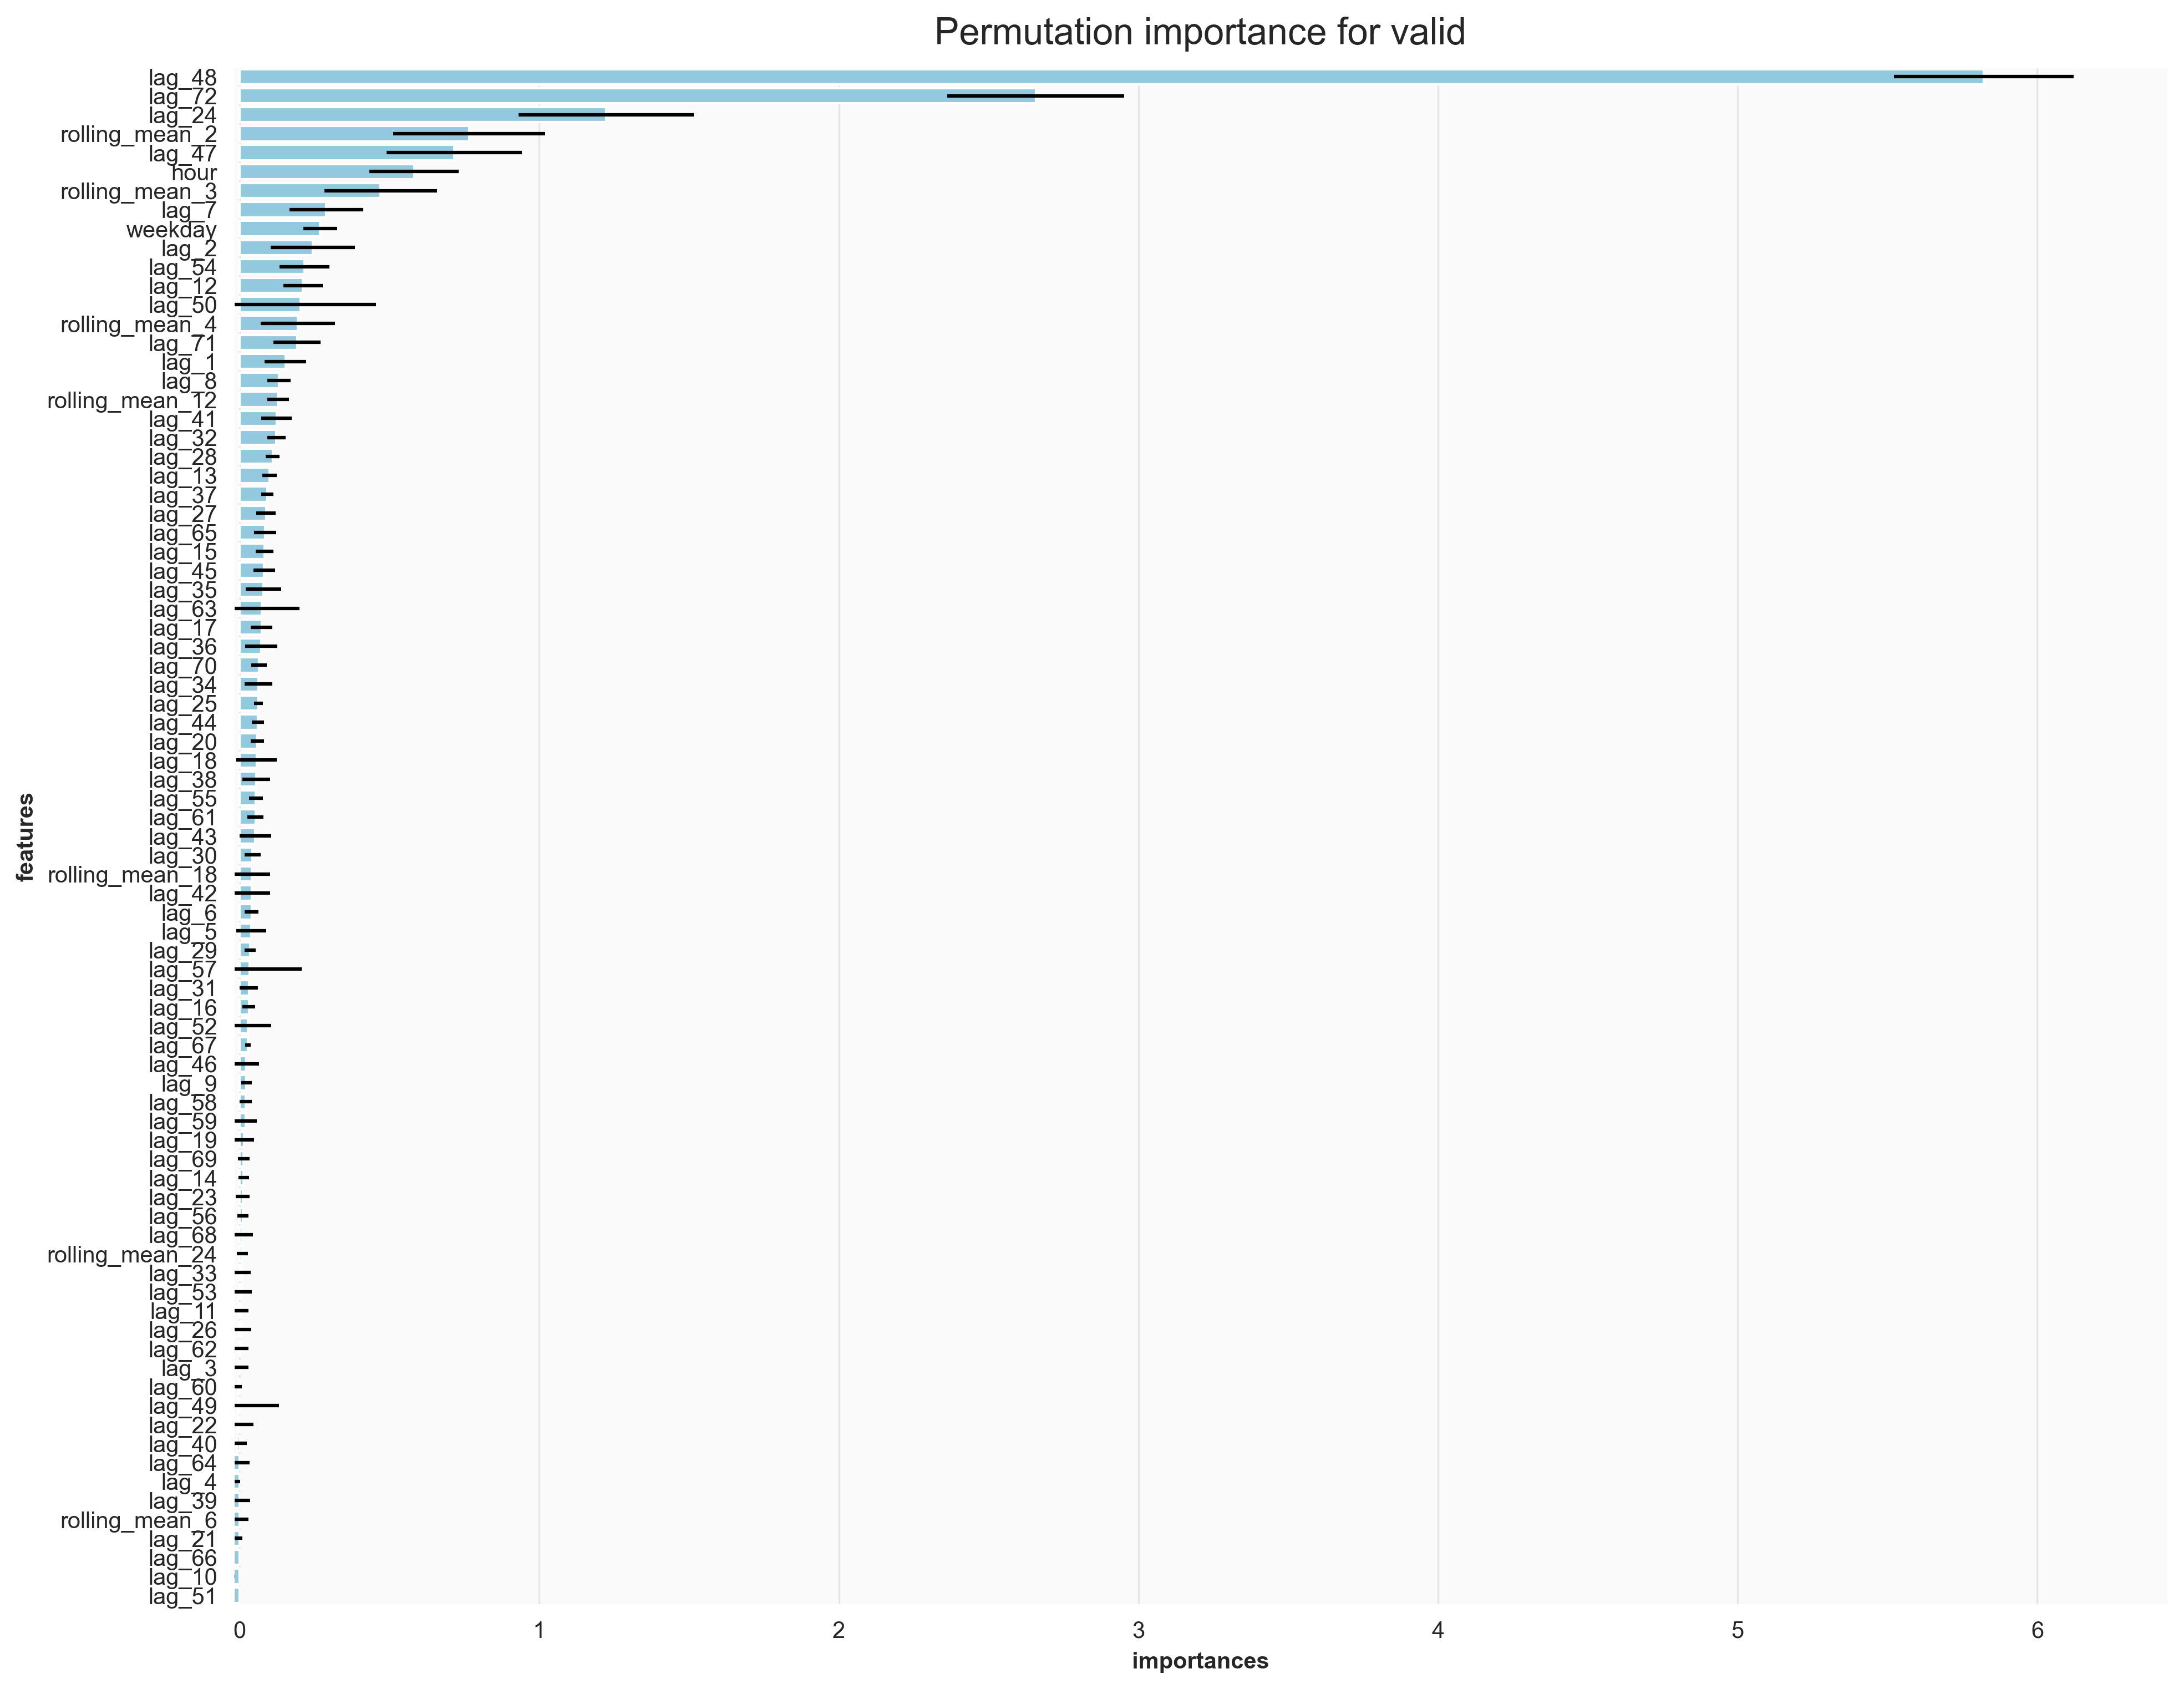

In [644]:
# permutation importance for train
plot_feature_importances(
                         'Permutation importance for train',
                         # извлечение списка признаков
                         model.feature_names_in_,
                         # вычисление важности признаков
                         permutation_importance(model,
                                                X_train, Y_train,
                                                scoring=SCORING, n_repeats=5, n_jobs=-1, random_state=RS)
                        )

# permutation importance for valid
plot_feature_importances(
                         'Permutation importance for valid',
                         # извлечение списка признаков
                         model.feature_names_in_,
                         # вычисление важности признаков
                         permutation_importance(model,
                                                X_valid, Y_valid,
                                                scoring=SCORING, n_repeats=5, n_jobs=-1, random_state=RS)
                        )

> Наиболее важными признаками оказались `lag_24`, `lag_48`, `lag_72` (в другом порядке, но это не принципиально), то есть количество заказов в этот же час одни сутки, двое и трое назад. Возможно, если продолжить этот ряд, это положительно скажется на модели.

> Вторая по важности группа признаков: `rolling_mean_2`, `rolling_mean_3` и т. д., то есть среднее количество заказов за некоторое количество предыдущих часов.  

> Также среди наиболее важных признаков — `hour`, номер часа.

---

## Вывод

### Краткий обзор проделанной работы

1. Проведен анализ временного ряда.
1. Подготовлены данные для модели.
1. Создано несколько различных моделей.
1. Выбрана и проанализирована лучшая модель.

### Анализ временного ряда

Входные данные ресемплированы с периодом 1 час.  
Проанализированы скользящее среднее и стандартное отклонение с периодом 7 дней.  
Проанализированы трендовость и цикличность временного ряда.  
Временной ряд проанализирован на стационарность.  
С помощью разности получены производные стационарные временные ряды. *Только непонятно, как их использовать для модели.*

### Моделирование

Сгенерированы новые признаки для модели: час заказа, день недели, ряд признаков на основе лага и ряд признаком на основе скользящего среднего.  
Созданы несколько моделей, из которых выбрана лучшая.  
RMSE лучшей модели для тестовой выборки равено 38, что соответствует поставленной задаче: получить RMSE менее 48.  
Судя по метрике R2, даже этот результат далек от идеала.